In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout, LSTM, Bidirectional, Concatenate
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
import random

# Load Excel Data
excel_file = "/content/drive/MyDrive/Tool_wear___1.xlsx"
data = pd.read_excel(excel_file)

# Extract columns
spindle_speed = data["Spindle speed (rpm)"].values
feed_rate = data["Feed/rev (mm/rev)"].values
depth = data["depth (mm)"].values
length = data["length (mm)"].values
area = data["Area (sq mm)"].values
image_numbers = data["image"].values

# Check for missing values
if np.any(np.isnan([spindle_speed, feed_rate, depth, length, area])):
    raise ValueError("Dataset contains missing values. Please clean the data.")

# Load and preprocess images
image_folder = "/content/drive/MyDrive/Images"
image_data = []
valid_indices = []

for i, img_number in enumerate(image_numbers):
    img_path = os.path.join(image_folder, f"{img_number}.jpg")
    if os.path.exists(img_path):
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        image_data.append(img_array)
        valid_indices.append(i)
    else:
        print(f"Warning: Image {img_number}.jpg missing. Skipping...")

# Remove missing entries
spindle_speed = spindle_speed[valid_indices]
feed_rate = feed_rate[valid_indices]
depth = depth[valid_indices]
length = length[valid_indices]
area = area[valid_indices]
image_data = np.array(image_data)

# Combine Numerical Inputs
numerical_inputs = np.column_stack((spindle_speed, feed_rate))

# Standardize Numerical Inputs
scaler = StandardScaler()
numerical_inputs_scaled = scaler.fit_transform(numerical_inputs)
joblib.dump(scaler, "scaler.pkl")

# Normalize Target Variables
target_scaler = MinMaxScaler()
y = target_scaler.fit_transform(np.column_stack((length, depth, area)))
joblib.dump(target_scaler, "target_scaler.pkl")

# Split Data
X_img_train, X_img_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    image_data, numerical_inputs_scaled, y, test_size=0.2, random_state=42
)

# Define Hybrid Model
image_input = Input(shape=(224, 224, 3), name="image_input")
base_model = EfficientNetB0(include_top=False, input_tensor=image_input, weights="imagenet", pooling="avg")
image_features = base_model.output

numerical_input = Input(shape=(2,), name="numerical_input")
numeric_lstm = Bidirectional(LSTM(16, return_sequences=False))(
    Lambda(lambda x: tf.expand_dims(x, axis=1))(numerical_input)
)

# Combine Features
combined = Concatenate()([image_features, numeric_lstm])

# Fully Connected Layers
x = Dense(256, activation="relu")(combined)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)

# Outputs
length_output = Dense(1, name="length_output")(x)
depth_output = Dense(1, name="depth_output")(x)
area_output = Dense(1, name="area_output")(x)

# Create Model
model = Model(inputs=[image_input, numerical_input], outputs=[length_output, depth_output, area_output])
model.compile(optimizer="adam", loss=["mse", "mse", "mse"], loss_weights=[1.0, 1.0, 2.0], metrics=[["mae"], ["mae"], ["mae"]])

# Callbacks
checkpoint_path = "best_model.h5"
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor="val_loss", save_best_only=True)

# Train Model
history = model.fit(
    [X_img_train, X_num_train],
    [y_train[:, 0], y_train[:, 1], y_train[:, 2]],
    validation_data=([X_img_test, X_num_test], [y_test[:, 0], y_test[:, 1], y_test[:, 2]]),
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping, model_checkpoint]
)

# Save Model
model.save("saved_hybrid_model.h5")

# Print Final Loss Value
final_loss = history.history["loss"][-1]
print(f"Final Training Loss: {final_loss:.4f}")

# Evaluate Model on Test Set
test_loss = model.evaluate([X_img_test, X_num_test], [y_test[:, 0], y_test[:, 1], y_test[:, 2]])
print(f"Total Test Loss: {test_loss[0]:.4f}")
print(f"Length Output Loss: {test_loss[1]:.4f}")
print(f"Depth Output Loss: {test_loss[2]:.4f}")
print(f"Area Output Loss: {test_loss[3]:.4f}")

# Test Model on a Random Sample
random_index = random.randint(0, len(X_img_test) - 1)

sample_image = np.expand_dims(X_img_test[random_index], axis=0)
sample_numerical = np.expand_dims(X_num_test[random_index], axis=0)

predictions = model.predict([sample_image, sample_numerical])

predicted_values = target_scaler.inverse_transform(
    np.array([predictions[0][0], predictions[1][0], predictions[2][0]]).reshape(1, -1)
)

# Print Predictions vs Actual
print("\n🔹 Predicted vs Actual Values 🔹")
print(f"Predicted Length: {predicted_values[0, 0]:.4f}, Actual Length: {y_test[random_index, 0]:.4f}")
print(f"Predicted Depth: {predicted_values[0, 1]:.4f}, Actual Depth: {y_test[random_index, 1]:.4f}")
print(f"Predicted Area: {predicted_values[0, 2]:.4f}, Actual Area: {y_test[random_index, 2]:.4f}")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75s/step - area_output_loss: 0.1628 - area_output_mae: 0.2827 - depth_output_loss: 0.2397 - depth_output_mae: 0.3911 - length_output_loss: 0.1941 - length_output_mae: 0.3157 - loss: 0.7595

1/1 ━━━━━━━━━━━━━━━━━━━━ 81s 81s/step - area_output_loss: 0.1628 - area_output_mae: 0.2827 - depth_output_loss: 0.2397 - depth_output_mae: 0.3911 - length_output_loss: 0.1941 - length_output_mae: 0.3157 - loss: 0.7595 - val_area_output_loss: 0.0071 - val_area_output_mae: 0.0733 - val_depth_output_loss: 0.0352 - val_depth_output_mae: 0.1666 - val_length_output_loss: 0.0238 - val_length_output_mae: 0.1385 - val_loss: 0.0733
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - area_output_loss: 0.1364 - area_output_mae: 0.3160 - depth_output_loss: 0.2316 - depth_output_mae: 0.3456 - length_output_loss: 0.1787 - length_output_mae: 0.3730 - loss: 0.6832 - val_area_output_loss: 0.0041 - val_area_output_mae: 0.0535 - val_depth_output_loss: 0.0477 - val_depth_output_mae: 0.2010 - val_length_output_loss: 0.0194 - val_length_output_mae: 0.1304 - val_loss: 0.0754
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - area_output_loss: 0.1045 - area_output_mae: 0.2221 - depth_output_loss: 0.2001 - depth_out

Final Training Loss: 0.1136
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - area_output_loss: 0.0071 - area_output_mae: 0.0733 - depth_output_loss: 0.0352 - depth_output_mae: 0.1666 - length_output_loss: 0.0238 - length_output_mae: 0.1385 - loss: 0.0733
Total Test Loss: 0.0733
Length Output Loss: 0.0238
Depth Output Loss: 0.0352
Area Output Loss: 0.0071
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

🔹 Predicted vs Actual Values 🔹
Predicted Length: 0.8654, Actual Length: 0.0057
Predicted Depth: 0.0110, Actual Depth: 0.0000
Predicted Area: 0.2643, Actual Area: 0.0241


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout, LSTM, Bidirectional, Concatenate
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
import random

# Load Excel Data
excel_file = "/content/drive/MyDrive/Tool_wear___1.xlsx"
data = pd.read_excel(excel_file)

# Extract columns
spindle_speed = data["Spindle speed (rpm)"].values
feed_rate = data["Feed/rev (mm/rev)"].values
depth = data["depth (mm)"].values
length = data["length (mm)"].values
area = data["Area (sq mm)"].values
image_numbers = data["image"].values

# Check for missing values
if np.any(np.isnan([spindle_speed, feed_rate, depth, length, area])):
    raise ValueError("Dataset contains missing values. Please clean the data.")

# Load and preprocess images
image_folder = "/content/drive/MyDrive/Images"
image_data = []
valid_indices = []

for i, img_number in enumerate(image_numbers):
    img_path = os.path.join(image_folder, f"{img_number}.jpg")
    if os.path.exists(img_path):
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        image_data.append(img_array)
        valid_indices.append(i)
    else:
        print(f"Warning: Image {img_number}.jpg missing. Skipping...")

# Remove missing entries
spindle_speed = spindle_speed[valid_indices]
feed_rate = feed_rate[valid_indices]
depth = depth[valid_indices]
length = length[valid_indices]
area = area[valid_indices]
image_data = np.array(image_data)

# Combine Numerical Inputs
numerical_inputs = np.column_stack((spindle_speed, feed_rate))

# Standardize Numerical Inputs
scaler = StandardScaler()
numerical_inputs_scaled = scaler.fit_transform(numerical_inputs)
joblib.dump(scaler, "scaler.pkl")

# Normalize Target Variables
target_scaler = MinMaxScaler()
y = target_scaler.fit_transform(np.column_stack((length, depth, area)))
joblib.dump(target_scaler, "target_scaler.pkl")

# Split Data
X_img_train, X_img_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    image_data, numerical_inputs_scaled, y, test_size=0.2, random_state=42
)

# Define Hybrid Model
image_input = Input(shape=(224, 224, 3), name="image_input")
base_model = EfficientNetB0(include_top=False, input_tensor=image_input, weights="imagenet", pooling="avg")
image_features = base_model.output

numerical_input = Input(shape=(2,), name="numerical_input")
numeric_lstm = Bidirectional(LSTM(16, return_sequences=False))(
    Lambda(lambda x: tf.expand_dims(x, axis=1))(numerical_input)
)

# Combine Features
combined = Concatenate()([image_features, numeric_lstm])

# Fully Connected Layers
x = Dense(256, activation="relu")(combined)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)

# Outputs
length_output = Dense(1, name="length_output")(x)
depth_output = Dense(1, name="depth_output")(x)
area_output = Dense(1, name="area_output")(x)

# Create Model
model = Model(inputs=[image_input, numerical_input], outputs=[length_output, depth_output, area_output])
model.compile(optimizer="adam", loss=["mse", "mse", "mse"], loss_weights=[2.0, 1.0, 2.0], metrics=[["mae"], ["mae"], ["mae"]])

# Callbacks
checkpoint_path = "best_model.h5"
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor="val_loss", save_best_only=True)

# Train Model
history = model.fit(
    [X_img_train, X_num_train],
    [y_train[:, 0], y_train[:, 1], y_train[:, 2]],
    validation_data=([X_img_test, X_num_test], [y_test[:, 0], y_test[:, 1], y_test[:, 2]]),
    epochs=50,
    batch_size=16,
    callbacks=[model_checkpoint]
)

# Save Model
model.save("saved_hybrid_model.h5")

# Print Final Loss Value
final_loss = history.history["loss"][-1]
print(f"Final Training Loss: {final_loss:.4f}")

# Evaluate Model on Test Set
test_loss = model.evaluate([X_img_test, X_num_test], [y_test[:, 0], y_test[:, 1], y_test[:, 2]])
print(f"Total Test Loss: {test_loss[0]:.4f}")
print(f"Length Output Loss: {test_loss[1]:.4f}")
print(f"Depth Output Loss: {test_loss[2]:.4f}")
print(f"Area Output Loss: {test_loss[3]:.4f}")

# Test Model on a Random Sample
random_index = random.randint(0, len(X_img_test) - 1)

sample_image = np.expand_dims(X_img_test[random_index], axis=0)
sample_numerical = np.expand_dims(X_num_test[random_index], axis=0)

predictions = model.predict([sample_image, sample_numerical])

predicted_values = target_scaler.inverse_transform(
    np.array([predictions[0][0], predictions[1][0], predictions[2][0]]).reshape(1, -1)
)

# Print Predictions vs Actual
print("\n🔹 Predicted vs Actual Values 🔹")
print(f"Predicted Length: {predicted_values[0, 0]:.4f}, Actual Length: {y_test[random_index, 0]:.4f}")
print(f"Predicted Depth: {predicted_values[0, 1]:.4f}, Actual Depth: {y_test[random_index, 1]:.4f}")
print(f"Predicted Area: {predicted_values[0, 2]:.4f}, Actual Area: {y_test[random_index, 2]:.4f}")


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60s/step - area_output_loss: 0.1237 - area_output_mae: 0.2456 - depth_output_loss: 0.4308 - depth_output_mae: 0.5122 - length_output_loss: 0.5406 - length_output_mae: 0.6793 - loss: 1.7594

1/1 ━━━━━━━━━━━━━━━━━━━━ 65s 65s/step - area_output_loss: 0.1237 - area_output_mae: 0.2456 - depth_output_loss: 0.4308 - depth_output_mae: 0.5122 - length_output_loss: 0.5406 - length_output_mae: 0.6793 - loss: 1.7594 - val_area_output_loss: 0.0215 - val_area_output_mae: 0.1419 - val_depth_output_loss: 0.0894 - val_depth_output_mae: 0.2737 - val_length_output_loss: 0.0478 - val_length_output_mae: 0.1947 - val_loss: 0.2280
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - area_output_loss: 0.0716 - area_output_mae: 0.2110 - depth_output_loss: 0.0949 - depth_output_mae: 0.2604 - length_output_loss: 0.2008 - length_output_mae: 0.3302 - loss: 0.6398

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - area_output_loss: 0.0716 - area_output_mae: 0.2110 - depth_output_loss: 0.0949 - depth_output_mae: 0.2604 - length_output_loss: 0.2008 - length_output_mae: 0.3302 - loss: 0.6398 - val_area_output_loss: 0.0233 - val_area_output_mae: 0.1489 - val_depth_output_loss: 0.0736 - val_depth_output_mae: 0.2473 - val_length_output_loss: 0.0410 - val_length_output_mae: 0.1783 - val_loss: 0.2021
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - area_output_loss: 0.0495 - area_output_mae: 0.1657 - depth_output_loss: 0.1455 - depth_output_mae: 0.2940 - length_output_loss: 0.1501 - length_output_mae: 0.3392 - loss: 0.5448

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - area_output_loss: 0.0495 - area_output_mae: 0.1657 - depth_output_loss: 0.1455 - depth_output_mae: 0.2940 - length_output_loss: 0.1501 - length_output_mae: 0.3392 - loss: 0.5448 - val_area_output_loss: 0.0283 - val_area_output_mae: 0.1650 - val_depth_output_loss: 0.0666 - val_depth_output_mae: 0.2336 - val_length_output_loss: 0.0268 - val_length_output_mae: 0.1333 - val_loss: 0.1767
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - area_output_loss: 0.1125 - area_output_mae: 0.2506 - depth_output_loss: 0.1364 - depth_output_mae: 0.2860 - length_output_loss: 0.6864 - length_output_mae: 0.5365 - loss: 1.7341

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - area_output_loss: 0.1125 - area_output_mae: 0.2506 - depth_output_loss: 0.1364 - depth_output_mae: 0.2860 - length_output_loss: 0.6864 - length_output_mae: 0.5365 - loss: 1.7341 - val_area_output_loss: 0.0279 - val_area_output_mae: 0.1639 - val_depth_output_loss: 0.0583 - val_depth_output_mae: 0.2154 - val_length_output_loss: 0.0144 - val_length_output_mae: 0.0980 - val_loss: 0.1428
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - area_output_loss: 0.2310 - area_output_mae: 0.3261 - depth_output_loss: 0.0683 - depth_output_mae: 0.1930 - length_output_loss: 0.1143 - length_output_mae: 0.2630 - loss: 0.7587

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - area_output_loss: 0.2310 - area_output_mae: 0.3261 - depth_output_loss: 0.0683 - depth_output_mae: 0.1930 - length_output_loss: 0.1143 - length_output_mae: 0.2630 - loss: 0.7587 - val_area_output_loss: 0.0129 - val_area_output_mae: 0.1083 - val_depth_output_loss: 0.0455 - val_depth_output_mae: 0.1832 - val_length_output_loss: 0.0108 - val_length_output_mae: 0.0948 - val_loss: 0.0930
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - area_output_loss: 0.1219 - area_output_mae: 0.2231 - depth_output_loss: 0.0596 - depth_output_mae: 0.2127 - length_output_loss: 0.1324 - length_output_mae: 0.2575 - loss: 0.5682

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - area_output_loss: 0.1219 - area_output_mae: 0.2231 - depth_output_loss: 0.0596 - depth_output_mae: 0.2127 - length_output_loss: 0.1324 - length_output_mae: 0.2575 - loss: 0.5682 - val_area_output_loss: 0.0060 - val_area_output_mae: 0.0690 - val_depth_output_loss: 0.0222 - val_depth_output_mae: 0.1163 - val_length_output_loss: 0.0131 - val_length_output_mae: 0.1043 - val_loss: 0.0603
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - area_output_loss: 0.1024 - area_output_mae: 0.2381 - depth_output_loss: 0.1117 - depth_output_mae: 0.2534 - length_output_loss: 0.1051 - length_output_mae: 0.2318 - loss: 0.5268

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - area_output_loss: 0.1024 - area_output_mae: 0.2381 - depth_output_loss: 0.1117 - depth_output_mae: 0.2534 - length_output_loss: 0.1051 - length_output_mae: 0.2318 - loss: 0.5268 - val_area_output_loss: 0.0020 - val_area_output_mae: 0.0420 - val_depth_output_loss: 0.0133 - val_depth_output_mae: 0.0946 - val_length_output_loss: 0.0162 - val_length_output_mae: 0.1122 - val_loss: 0.0497
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - area_output_loss: 0.0444 - area_output_mae: 0.1604 - depth_output_loss: 0.1240 - depth_output_mae: 0.2692 - length_output_loss: 0.0818 - length_output_mae: 0.2431 - loss: 0.3764

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - area_output_loss: 0.0444 - area_output_mae: 0.1604 - depth_output_loss: 0.1240 - depth_output_mae: 0.2692 - length_output_loss: 0.0818 - length_output_mae: 0.2431 - loss: 0.3764 - val_area_output_loss: 0.0012 - val_area_output_mae: 0.0344 - val_depth_output_loss: 0.0110 - val_depth_output_mae: 0.0913 - val_length_output_loss: 0.0178 - val_length_output_mae: 0.1169 - val_loss: 0.0489
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - area_output_loss: 0.0698 - area_output_mae: 0.2123 - depth_output_loss: 0.0917 - depth_output_mae: 0.2294 - length_output_loss: 0.0804 - length_output_mae: 0.2310 - loss: 0.3922

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - area_output_loss: 0.0698 - area_output_mae: 0.2123 - depth_output_loss: 0.0917 - depth_output_mae: 0.2294 - length_output_loss: 0.0804 - length_output_mae: 0.2310 - loss: 0.3922 - val_area_output_loss: 0.0011 - val_area_output_mae: 0.0295 - val_depth_output_loss: 0.0115 - val_depth_output_mae: 0.0955 - val_length_output_loss: 0.0162 - val_length_output_mae: 0.1134 - val_loss: 0.0461
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - area_output_loss: 0.0472 - area_output_mae: 0.1527 - depth_output_loss: 0.1540 - depth_output_mae: 0.2946 - length_output_loss: 0.0531 - length_output_mae: 0.1806 - loss: 0.3545 - val_area_output_loss: 0.0014 - val_area_output_mae: 0.0259 - val_depth_output_loss: 0.0120 - val_depth_output_mae: 0.0998 - val_length_output_loss: 0.0163 - val_length_output_mae: 0.1135 - val_loss: 0.0474
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - area_output_loss: 0.0165 - area_output_mae: 0.1027 - depth_output_loss: 0.0633 - depth_out

Final Training Loss: 0.1014
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - area_output_loss: 0.0573 - area_output_mae: 0.2373 - depth_output_loss: 0.0248 - depth_output_mae: 0.1268 - length_output_loss: 0.0172 - length_output_mae: 0.1035 - loss: 0.1738
Total Test Loss: 0.1738
Length Output Loss: 0.0172
Depth Output Loss: 0.0248
Area Output Loss: 0.0573
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

🔹 Predicted vs Actual Values 🔹
Predicted Length: 1.2183, Actual Length: 0.3403
Predicted Depth: 0.1541, Actual Depth: 0.1042
Predicted Area: 0.6406, Actual Area: 0.0922


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout, LSTM, Bidirectional, Concatenate
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
import random

# Load Excel Data
excel_file = "/content/drive/MyDrive/Tool_wear___1.xlsx"
data = pd.read_excel(excel_file)

# Extract columns
spindle_speed = data["Spindle speed (rpm)"].values
feed_rate = data["Feed/rev (mm/rev)"].values
depth = data["depth (mm)"].values
length = data["length (mm)"].values
area = data["Area (sq mm)"].values
image_numbers = data["image"].values

# Check for missing values
if np.any(np.isnan([spindle_speed, feed_rate, depth, length, area])):
    raise ValueError("Dataset contains missing values. Please clean the data.")

# Load and preprocess images
image_folder = "/content/drive/MyDrive/Images"
image_data = []
valid_indices = []

for i, img_number in enumerate(image_numbers):
    img_path = os.path.join(image_folder, f"{img_number}.jpg")
    if os.path.exists(img_path):
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        image_data.append(img_array)
        valid_indices.append(i)
    else:
        print(f"Warning: Image {img_number}.jpg missing. Skipping...")

# Remove missing entries
spindle_speed = spindle_speed[valid_indices]
feed_rate = feed_rate[valid_indices]
depth = depth[valid_indices]
length = length[valid_indices]
area = area[valid_indices]
image_data = np.array(image_data)

# Combine Numerical Inputs
numerical_inputs = np.column_stack((spindle_speed, feed_rate))

# Standardize Numerical Inputs
scaler = StandardScaler()
numerical_inputs_scaled = scaler.fit_transform(numerical_inputs)
joblib.dump(scaler, "scaler.pkl")

# Normalize Target Variables
target_scaler = MinMaxScaler()
y = target_scaler.fit_transform(np.column_stack((length, depth, area)))
joblib.dump(target_scaler, "target_scaler.pkl")

# Split Data
X_img_train, X_img_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    image_data, numerical_inputs_scaled, y, test_size=0.2, random_state=42
)

# Define Hybrid Model
image_input = Input(shape=(224, 224, 3), name="image_input")
base_model = EfficientNetB0(include_top=False, input_tensor=image_input, weights="imagenet", pooling="avg")
image_features = base_model.output

numerical_input = Input(shape=(2,), name="numerical_input")
numeric_lstm = Bidirectional(LSTM(16, return_sequences=False))(
    Lambda(lambda x: tf.expand_dims(x, axis=1))(numerical_input)
)

# Combine Features
combined = Concatenate()([image_features, numeric_lstm])

# Fully Connected Layers
x = Dense(256, activation="relu")(combined)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)

# Outputs
length_output = Dense(1, name="length_output")(x)
depth_output = Dense(1, name="depth_output")(x)
area_output = Dense(1, name="area_output")(x)

# Create Model
model = Model(inputs=[image_input, numerical_input], outputs=[length_output, depth_output, area_output])
model.compile(optimizer="adam", loss=["mse", "mse", "mse"], loss_weights=[2.0, 2.0, 2.0], metrics=[["mae"], ["mae"], ["mae"]])

# Callbacks
checkpoint_path = "best_model.h5"
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor="val_loss", save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train Model
history = model.fit(
    [X_img_train, X_num_train],
    [y_train[:, 0], y_train[:, 1], y_train[:, 2]],
    validation_data=([X_img_test, X_num_test], [y_test[:, 0], y_test[:, 1], y_test[:, 2]]),
    epochs=50,
    batch_size=16,
    callbacks=[model_checkpoint, early_stopping]
)

# Save Model
model.save("saved_hybrid_model.h5")

# Print Final Loss Value
final_loss = history.history["loss"][-1]
print(f"Final Training Loss: {final_loss:.4f}")

# Evaluate Model on Test Set
test_loss = model.evaluate([X_img_test, X_num_test], [y_test[:, 0], y_test[:, 1], y_test[:, 2]])
print(f"Total Test Loss: {test_loss[0]:.4f}")
print(f"Length Output Loss: {test_loss[1]:.4f}")
print(f"Depth Output Loss: {test_loss[2]:.4f}")
print(f"Area Output Loss: {test_loss[3]:.4f}")

# Test Model on a Random Sample
random_index = random.randint(0, len(X_img_test) - 1)

sample_image = np.expand_dims(X_img_test[random_index], axis=0)
sample_numerical = np.expand_dims(X_num_test[random_index], axis=0)

predictions = model.predict([sample_image, sample_numerical])

predicted_values = target_scaler.inverse_transform(
    np.array([predictions[0][0], predictions[1][0], predictions[2][0]]).reshape(1, -1)
)

# Print Predictions vs Actual
print("\n🔹 Predicted vs Actual Values 🔹")
print(f"Predicted Length: {predicted_values[0, 0]:.4f}, Actual Length: {y_test[random_index, 0]:.4f}")
print(f"Predicted Depth: {predicted_values[0, 1]:.4f}, Actual Depth: {y_test[random_index, 1]:.4f}")
print(f"Predicted Area: {predicted_values[0, 2]:.4f}, Actual Area: {y_test[random_index, 2]:.4f}")


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64s/step - area_output_loss: 0.1687 - area_output_mae: 0.2859 - depth_output_loss: 0.1920 - depth_output_mae: 0.3839 - length_output_loss: 0.2971 - length_output_mae: 0.4659 - loss: 1.3155

1/1 ━━━━━━━━━━━━━━━━━━━━ 69s 69s/step - area_output_loss: 0.1687 - area_output_mae: 0.2859 - depth_output_loss: 0.1920 - depth_output_mae: 0.3839 - length_output_loss: 0.2971 - length_output_mae: 0.4659 - loss: 1.3155 - val_area_output_loss: 9.4598e-04 - val_area_output_mae: 0.0287 - val_depth_output_loss: 0.0137 - val_depth_output_mae: 0.1079 - val_length_output_loss: 0.0703 - val_length_output_mae: 0.2476 - val_loss: 0.1699
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - area_output_loss: 0.1470 - area_output_mae: 0.2962 - depth_output_loss: 0.1451 - depth_output_mae: 0.3119 - length_output_loss: 0.2200 - length_output_mae: 0.3642 - loss: 1.0244

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - area_output_loss: 0.1470 - area_output_mae: 0.2962 - depth_output_loss: 0.1451 - depth_output_mae: 0.3119 - length_output_loss: 0.2200 - length_output_mae: 0.3642 - loss: 1.0244 - val_area_output_loss: 9.4868e-04 - val_area_output_mae: 0.0288 - val_depth_output_loss: 0.0126 - val_depth_output_mae: 0.1042 - val_length_output_loss: 0.0700 - val_length_output_mae: 0.2474 - val_loss: 0.1671
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - area_output_loss: 0.0560 - area_output_mae: 0.1675 - depth_output_loss: 0.1023 - depth_output_mae: 0.2516 - length_output_loss: 0.0789 - length_output_mae: 0.2177 - loss: 0.4744

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - area_output_loss: 0.0560 - area_output_mae: 0.1675 - depth_output_loss: 0.1023 - depth_output_mae: 0.2516 - length_output_loss: 0.0789 - length_output_mae: 0.2177 - loss: 0.4744 - val_area_output_loss: 0.0010 - val_area_output_mae: 0.0305 - val_depth_output_loss: 0.0121 - val_depth_output_mae: 0.0997 - val_length_output_loss: 0.0620 - val_length_output_mae: 0.2300 - val_loss: 0.1501
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - area_output_loss: 0.1151 - area_output_mae: 0.2717 - depth_output_loss: 0.1139 - depth_output_mae: 0.2400 - length_output_loss: 0.1133 - length_output_mae: 0.2163 - loss: 0.6846

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - area_output_loss: 0.1151 - area_output_mae: 0.2717 - depth_output_loss: 0.1139 - depth_output_mae: 0.2400 - length_output_loss: 0.1133 - length_output_mae: 0.2163 - loss: 0.6846 - val_area_output_loss: 0.0016 - val_area_output_mae: 0.0365 - val_depth_output_loss: 0.0131 - val_depth_output_mae: 0.1065 - val_length_output_loss: 0.0495 - val_length_output_mae: 0.2010 - val_loss: 0.1284
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - area_output_loss: 0.1196 - area_output_mae: 0.2442 - depth_output_loss: 0.0684 - depth_output_mae: 0.1619 - length_output_loss: 0.1813 - length_output_mae: 0.2534 - loss: 0.7388

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - area_output_loss: 0.1196 - area_output_mae: 0.2442 - depth_output_loss: 0.0684 - depth_output_mae: 0.1619 - length_output_loss: 0.1813 - length_output_mae: 0.2534 - loss: 0.7388 - val_area_output_loss: 0.0032 - val_area_output_mae: 0.0480 - val_depth_output_loss: 0.0172 - val_depth_output_mae: 0.1195 - val_length_output_loss: 0.0369 - val_length_output_mae: 0.1676 - val_loss: 0.1147
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - area_output_loss: 0.1862 - area_output_mae: 0.3099 - depth_output_loss: 0.0470 - depth_output_mae: 0.1501 - length_output_loss: 0.0996 - length_output_mae: 0.2493 - loss: 0.6657

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - area_output_loss: 0.1862 - area_output_mae: 0.3099 - depth_output_loss: 0.0470 - depth_output_mae: 0.1501 - length_output_loss: 0.0996 - length_output_mae: 0.2493 - loss: 0.6657 - val_area_output_loss: 0.0045 - val_area_output_mae: 0.0596 - val_depth_output_loss: 0.0230 - val_depth_output_mae: 0.1315 - val_length_output_loss: 0.0240 - val_length_output_mae: 0.1235 - val_loss: 0.1032
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - area_output_loss: 0.1676 - area_output_mae: 0.2714 - depth_output_loss: 0.0468 - depth_output_mae: 0.1660 - length_output_loss: 0.1401 - length_output_mae: 0.3112 - loss: 0.7089

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - area_output_loss: 0.1676 - area_output_mae: 0.2714 - depth_output_loss: 0.0468 - depth_output_mae: 0.1660 - length_output_loss: 0.1401 - length_output_mae: 0.3112 - loss: 0.7089 - val_area_output_loss: 0.0037 - val_area_output_mae: 0.0529 - val_depth_output_loss: 0.0258 - val_depth_output_mae: 0.1337 - val_length_output_loss: 0.0154 - val_length_output_mae: 0.0948 - val_loss: 0.0899
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - area_output_loss: 0.0810 - area_output_mae: 0.1955 - depth_output_loss: 0.0511 - depth_output_mae: 0.1683 - length_output_loss: 0.1542 - length_output_mae: 0.2668 - loss: 0.5725

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - area_output_loss: 0.0810 - area_output_mae: 0.1955 - depth_output_loss: 0.0511 - depth_output_mae: 0.1683 - length_output_loss: 0.1542 - length_output_mae: 0.2668 - loss: 0.5725 - val_area_output_loss: 0.0022 - val_area_output_mae: 0.0395 - val_depth_output_loss: 0.0289 - val_depth_output_mae: 0.1371 - val_length_output_loss: 0.0112 - val_length_output_mae: 0.0847 - val_loss: 0.0846
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - area_output_loss: 0.1416 - area_output_mae: 0.2495 - depth_output_loss: 0.1001 - depth_output_mae: 0.2356 - length_output_loss: 0.3230 - length_output_mae: 0.3185 - loss: 1.1294 - val_area_output_loss: 0.0021 - val_area_output_mae: 0.0401 - val_depth_output_loss: 0.0308 - val_depth_output_mae: 0.1407 - val_length_output_loss: 0.0100 - val_length_output_mae: 0.0811 - val_loss: 0.0860
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - area_output_loss: 0.0504 - area_output_mae: 0.1667 - depth_output_loss: 0.0947 - depth_outp

Final Training Loss: 0.3195
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - area_output_loss: 0.0022 - area_output_mae: 0.0395 - depth_output_loss: 0.0289 - depth_output_mae: 0.1371 - length_output_loss: 0.0112 - length_output_mae: 0.0847 - loss: 0.0846
Total Test Loss: 0.0846
Length Output Loss: 0.0112
Depth Output Loss: 0.0289
Area Output Loss: 0.0022
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

🔹 Predicted vs Actual Values 🔹
Predicted Length: 1.3776, Actual Length: 0.1052
Predicted Depth: 0.1562, Actual Depth: 0.2500
Predicted Area: 0.0891, Actual Area: 0.0777


RMSE and r2 value calculation

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.image import resize

# 🟩 Fix: Ensure input images are resized to 224x224
def resize_images(images):
    return np.array([resize(img, (224, 224)).numpy() for img in images])

# 🟩 Example data (replace with actual data loading)
X_img_train = np.random.rand(100, 224, 224, 3)
X_img_test = np.random.rand(20, 224, 224, 3)
X_num_train = np.random.rand(100, 10)
X_num_test = np.random.rand(20, 10)
y_train = np.random.rand(100, 3)
y_test = np.random.rand(20, 3)

# 🟩 Resize images if they are not 224x224
if X_img_train.shape[1:3] != (224, 224):
    X_img_train = resize_images(X_img_train)
    X_img_test = resize_images(X_img_test)

# 🟩 Define the model
img_input = Input(shape=(224, 224, 3), name="img_input")
num_input = Input(shape=(10,), name="num_input")

# 🟩 CNN for image input
x = Conv2D(32, (3, 3), activation='relu')(img_input)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

# 🟩 Fully connected layers for numerical input
y = Dense(32, activation='relu')(num_input)
y = Dropout(0.2)(y)
y = Dense(16, activation='relu')(y)

# 🟩 Concatenate and build the final model
combined = Concatenate()([x, y])
combined = Dense(64, activation='relu')(combined)

output1 = Dense(1, name='length_output')(combined)
output2 = Dense(1, name='depth_output')(combined)
output3 = Dense(1, name='area_output')(combined)

model = Model(inputs=[img_input, num_input], outputs=[output1, output2, output3])
# 🟩 Compile the model with separate metrics for each output
model.compile(optimizer='adam', loss='huber', metrics=[['mae'], ['mae'], ['mae']])



# 🟩 Train Model
history = model.fit(
    [X_img_train, X_num_train],
    [y_train[:, 0], y_train[:, 1], y_train[:, 2]],
    validation_split=0.2,
    epochs=50,  # Increase epochs
    batch_size=8
)

# 🟩 Save the model in recommended format
model.save('hybrid_model.keras')

# 🟩 Make Predictions
preds = model.predict([X_img_test, X_num_test])
preds = np.array(preds).T[0]

# 🟩 Evaluate Model
for i, (name, actual, pred) in enumerate(zip(['Length', 'Depth', 'Area'], y_test.T, preds.T)):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    r2 = r2_score(actual, pred)
    print(f"{name} RMSE: {rmse:.3f} mm, R²: {r2:.3f}")

# 🟩 Display Sample Predictions
print("\n🔹 Predicted vs Actual Values 🔹")
for i in range(5):
    print(f"Predicted Length: {preds[i][0]:.4f} mm, Actual Length: {y_test[i, 0]:.4f} mm")
    print(f"Predicted Depth: {preds[i][1]:.4f} mm, Actual Depth: {y_test[i, 1]:.4f} mm")
    print(f"Predicted Area: {preds[i][2]:.4f} mm², Actual Area: {y_test[i, 2]:.4f} mm²\n")


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - area_output_loss: 1.7167 - area_output_mae: 2.1311 - depth_output_loss: 2.4906 - depth_output_mae: 2.8376 - length_output_loss: 6.6246 - length_output_mae: 7.0831 - loss: 10.8319 - val_area_output_loss: 0.0629 - val_area_output_mae: 0.3056 - val_depth_output_loss: 0.0969 - val_depth_output_mae: 0.3524 - val_length_output_loss: 0.1768 - val_length_output_mae: 0.5133 - val_loss: 0.3371
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - area_output_loss: 0.0647 - area_output_mae: 0.2975 - depth_output_loss: 0.0700 - depth_output_mae: 0.3259 - length_output_loss: 0.0974 - length_output_mae: 0.3654 - loss: 0.2320 - val_area_output_loss: 0.0705 - val_area_output_mae: 0.3246 - val_depth_output_loss: 0.0968 - val_depth_output_mae: 0.3527 - val_length_output_loss: 0.1108 - val_length_output_mae: 0.3759 - val_loss: 0.2799
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 917ms/step - area_output_loss: 0.0484 - area_output_mae: 0.2630 - depth_output_lo

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.image import resize
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# 🟩 Normalize Image Data and Resize to (128, 128, 3)
X_img_train = np.array([resize(img, (128, 128)).numpy() / 255.0 for img in X_img_train])
X_img_test = np.array([resize(img, (128, 128)).numpy() / 255.0 for img in X_img_test])

# 🟩 Standardize Numerical Data
num_scaler = StandardScaler()
X_num_train = num_scaler.fit_transform(X_num_train)
X_num_test = num_scaler.transform(X_num_test)

# 🟩 Normalize Target Values
target_scaler = MinMaxScaler()
y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

# 🟩 Define Image Input Branch
img_input = Input(shape=(128, 128, 3))
x = Conv2D(32, (3, 3), activation='relu')(img_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

# 🟩 Define Numerical Input Branch
num_input = Input(shape=(X_num_train.shape[1],))
y = Dense(32, activation='relu')(num_input)
y = Dropout(0.3)(y)
y = Dense(16, activation='relu')(y)

# 🟩 Merge Both Branches
merged = Concatenate()([x, y])
z = Dense(32, activation='relu')(merged)  # Reduced neurons to 32
z = Dropout(0.3)(z)

# 🟩 Define Outputs for Length, Depth, and Area with Proper Activation
length_output = Dense(1, activation='linear', name='length_output')(z)
depth_output = Dense(1, activation='linear', name='depth_output')(z)
area_output = Dense(1, activation='linear', name='area_output')(z)

# 🟩 Build and Compile Model with Separate Metrics
model = Model(inputs=[img_input, num_input], outputs=[length_output, depth_output, area_output])
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mae',  # Use MAE for robustness against outliers
              metrics={'length_output': RootMeanSquaredError(),
                       'depth_output': RootMeanSquaredError(),
                       'area_output': RootMeanSquaredError()})

# 🟩 Train Model
history = model.fit(
    [X_img_train, X_num_train],
    [y_train[:, 0], y_train[:, 1], y_train[:, 2]],
    validation_split=0.2,
    epochs=20,
    batch_size=8
)

# 🟩 Evaluate Model
results = model.evaluate([X_img_test, X_num_test], [y_test[:, 0], y_test[:, 1], y_test[:, 2]])
print("\n🔹 Evaluation Results 🔹")
for i, name in enumerate(['Length', 'Depth', 'Area']):
    print(f"{name} Loss: {results[i * 2]:.4f}, RMSE: {results[i * 2 + 1]:.4f}")

# 🟩 Predictions
predictions = model.predict([X_img_test, X_num_test])

# 🟩 Calculate RMSE and R² Scores
print("\n🔹 RMSE and R² Scores 🔹")
for i, name in enumerate(['Length', 'Depth', 'Area']):
    # Reshape predictions to match scaler's expected input shape
    pred_rescaled = target_scaler.inverse_transform(np.concatenate([
        predictions[0], predictions[1], predictions[2]
    ], axis=1))[:, i]

    # Reshape actual target values similarly
    actual_rescaled = target_scaler.inverse_transform(y_test)[:, i]

    rmse = np.sqrt(mean_squared_error(actual_rescaled, pred_rescaled))
    r2 = r2_score(actual_rescaled, pred_rescaled)
    print(f"{name} RMSE: {rmse:.3f} mm, R²: {r2:.3f}")

# 🟩 Display Predicted vs Actual Values
print("\n🔹 Predicted vs Actual Values 🔹")
pred_rescaled = target_scaler.inverse_transform(np.concatenate([
    predictions[0], predictions[1], predictions[2]
], axis=1))

for i in range(5):
    print(f"Predicted Length: {pred_rescaled[i, 0]:.4f} mm, Actual Length: {y_test[i, 0]:.4f} mm")
    print(f"Predicted Depth: {pred_rescaled[i, 1]:.4f} mm, Actual Depth: {y_test[i, 1]:.4f} mm")
    print(f"Predicted Area: {pred_rescaled[i, 2]:.4f} mm², Actual Area: {y_test[i, 2]:.4f} mm²\n")


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 696ms/step - area_output_loss: 0.4070 - area_output_root_mean_squared_error: 0.5060 - depth_output_loss: 0.4469 - depth_output_root_mean_squared_error: 0.5163 - length_output_loss: 0.3507 - length_output_root_mean_squared_error: 0.4305 - loss: 1.2045 - val_area_output_loss: 0.3050 - val_area_output_root_mean_squared_error: 0.3983 - val_depth_output_loss: 0.2752 - val_depth_output_root_mean_squared_error: 0.3291 - val_length_output_loss: 0.3269 - val_length_output_root_mean_squared_error: 0.3758 - val_loss: 0.9230
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - area_output_loss: 0.2971 - area_output_root_mean_squared_error: 0.3614 - depth_output_loss: 0.2768 - depth_output_root_mean_squared_error: 0.3376 - length_output_loss: 0.2772 - length_output_root_mean_squared_error: 0.3295 - loss: 0.8511 - val_area_output_loss: 0.3095 - val_area_output_root_mean_squared_error: 0.4030 - val_depth_output_loss: 0.3161 - val_depth_output_root_mean_squar

CNN+LSTM

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Concatenate, Bidirectional, Attention, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load Excel Data
excel_file = "/content/drive/MyDrive/Tool_wear___1.xlsx"
data = pd.read_excel(excel_file)

# Extract columns
spindle_speed = data["Spindle speed (rpm)"].values
feed_rate = data["Feed/rev (mm/rev)"].values
depth = data["depth (mm)"].values
length = data["length (mm)"].values
area = data["Area (sq mm)"].values
image_numbers = data["image"].values

# Check for missing values
if np.any(np.isnan([spindle_speed, feed_rate, depth, length, area])):
    raise ValueError("Dataset contains missing values. Please clean the data.")

# Load and preprocess images
image_folder = "/content/drive/MyDrive/Images"
image_data = []
valid_indices = []

for i, img_number in enumerate(image_numbers):
    img_path = os.path.join(image_folder, f"{img_number}.jpg")
    if os.path.exists(img_path):
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        image_data.append(img_array)
        valid_indices.append(i)
    else:
        print(f"Warning: Image {img_number}.jpg missing. Skipping...")

# Remove missing entries
spindle_speed = spindle_speed[valid_indices]
feed_rate = feed_rate[valid_indices]
depth = depth[valid_indices]
length = length[valid_indices]
area = area[valid_indices]
image_data = np.array(image_data)

# Combine Numerical Inputs
numerical_inputs = np.column_stack((spindle_speed, feed_rate))

# Standardize Numerical Inputs
scaler = StandardScaler()
numerical_inputs_scaled = scaler.fit_transform(numerical_inputs)
joblib.dump(scaler, "scaler.pkl")

# Normalize Target Variables
target_scaler = MinMaxScaler()
y = target_scaler.fit_transform(np.column_stack((length, depth, area)))
joblib.dump(target_scaler, "target_scaler.pkl")

# Split Data
X_img_train, X_img_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    image_data, numerical_inputs_scaled, y, test_size=0.2, random_state=42
)

# Normalize numerical data
scaler = MinMaxScaler()
X_num_train = scaler.fit_transform(X_num_train)
X_num_test = scaler.transform(X_num_test)

# Separate scalers for each target
length_scaler = MinMaxScaler()
depth_scaler = MinMaxScaler()
area_scaler = MinMaxScaler()

y_train_length = length_scaler.fit_transform(y_train[:, 0].reshape(-1, 1))
y_train_depth = depth_scaler.fit_transform(y_train[:, 1].reshape(-1, 1))
y_train_area = area_scaler.fit_transform(y_train[:, 2].reshape(-1, 1))

y_test_length = length_scaler.transform(y_test[:, 0].reshape(-1, 1))
y_test_depth = depth_scaler.transform(y_test[:, 1].reshape(-1, 1))
y_test_area = area_scaler.transform(y_test[:, 2].reshape(-1, 1))

# 🟩 CNN for Image Data
img_input = Input(shape=(224, 224, 3))
cnn = Conv2D(32, (3, 3), activation='relu')(img_input)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Conv2D(64, (3, 3), activation='relu')(cnn)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Flatten()(cnn)

# 🟩 Bi-LSTM for Sequential Data
seq_input = Input(shape=(X_num_train.shape[1], 1))
lstm = Bidirectional(LSTM(64, return_sequences=True))(seq_input)
lstm = Bidirectional(LSTM(32, return_sequences=True))(lstm)

# 🟩 Attention Mechanism
attention = Attention()([lstm, lstm])
lstm = GlobalAveragePooling1D()(attention)  # Fix: Use Keras layer instead of tf.reduce_mean

# 🟩 Combine Features
combined = Concatenate()([cnn, lstm])

# 🟩 Fully Connected Layers
fc = Dense(128, activation='relu')(combined)
fc = Dense(64, activation='relu')(fc)

# 🟩 Output Layers for Each Target
out_length = Dense(1, name='length')(fc)
out_depth = Dense(1, name='depth')(fc)
out_area = Dense(1, name='area')(fc)

# 🟩 Define Model
model = Model(inputs=[img_input, seq_input], outputs=[out_length, out_depth, out_area])
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=['mse', 'mse', 'mse'],  # 🟩 Loss for each output
    metrics=[['mae'], ['mae'], ['mae']]  # 🟩 Metrics for each output
)
model.summary()

model.summary()

# 🟩 Train Model
history = model.fit(
    [X_img_train, X_num_train.reshape(-1, X_num_train.shape[1], 1)],
    [y_train_length, y_train_depth, y_train_area],
    validation_split=0.2,
    epochs=50,
    batch_size=8
)

# 🟩 Evaluate Model
results = model.evaluate(
    [X_img_test, X_num_test.reshape(-1, X_num_test.shape[1], 1)],
    [y_test_length, y_test_depth, y_test_area]
)

# 🟩 Predictions
predictions = model.predict([X_img_test, X_num_test.reshape(-1, X_num_test.shape[1], 1)])

# 🟩 Rescale Predictions to Original Scale
pred_length = length_scaler.inverse_transform(predictions[0])
pred_depth = depth_scaler.inverse_transform(predictions[1])
pred_area = area_scaler.inverse_transform(predictions[2])

y_test_length_rescaled = length_scaler.inverse_transform(y_test_length)
y_test_depth_rescaled = depth_scaler.inverse_transform(y_test_depth)
y_test_area_rescaled = area_scaler.inverse_transform(y_test_area)

# 🟩 Calculate RMSE and R² Scores
print("\n🔹 RMSE and R² Scores 🔹")
for pred_rescaled, actual_rescaled, name in zip(
    [pred_length, pred_depth, pred_area],
    [y_test_length_rescaled, y_test_depth_rescaled, y_test_area_rescaled],
    ['Length', 'Depth', 'Area']
):
    rmse = np.sqrt(mean_squared_error(actual_rescaled, pred_rescaled))
    r2 = r2_score(actual_rescaled, pred_rescaled)
    print(f"{name} RMSE: {rmse:.3f}, R²: {r2:.3f}")

# 🟩 Display Predicted vs Actual Values
print("\n🔹 Predicted vs Actual Values 🔹")
for i in range(len(pred_length)):
    print(f"Predicted Length: {pred_length[i][0]:.4f}, Actual Length: {y_test_length_rescaled[i][0]:.4f}")
    print(f"Predicted Depth: {pred_depth[i][0]:.4f}, Actual Depth: {y_test_depth_rescaled[i][0]:.4f}")
    print(f"Predicted Area: {pred_area[i][0]:.4f}, Actual Area: {y_test_area_rescaled[i][0]:.4f}\n")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 222, 222, 32)   │            896 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 2, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 111, 111, 32)   │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_6           │ (None, 2, 128)         │         33,792 │ input_layer_7[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 109, 109, 64)   │         18,496 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_7           │ (None, 2, 64)          │         41,216 │ bidirectional_6[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 54, 54, 64)     │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_3 (Attention)   │ (None, 2, 64)          │              0 │ bidirectional_7[0][0], │
│                           │                        │                │ bidirectional_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 186624)         │              0 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ attention_3[0][0]      │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 186688)         │              0 │ flatten_3[0][0],       │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │     23,896,192 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │          8,256 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ length (Dense)            │ (None, 1)              │             65 │ dense_5[0][0]          │
├──────────────────────

 Total params: 23,999,043 (91.55 MB)

 Trainable params: 23,999,043 (91.55 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 222, 222, 32)   │            896 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 2, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 111, 111, 32)   │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_6           │ (None, 2, 128)         │         33,792 │ input_layer_7[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 109, 109, 64)   │         18,496 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_7           │ (None, 2, 64)          │         41,216 │ bidirectional_6[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 54, 54, 64)     │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_3 (Attention)   │ (None, 2, 64)          │              0 │ bidirectional_7[0][0], │
│                           │                        │                │ bidirectional_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 186624)         │              0 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ attention_3[0][0]      │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 186688)         │              0 │ flatten_3[0][0],       │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │     23,896,192 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │          8,256 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ length (Dense)            │ (None, 1)              │             65 │ dense_5[0][0]          │
├──────────────────────

 Total params: 23,999,043 (91.55 MB)

 Trainable params: 23,999,043 (91.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - area_loss: 0.1099 - area_mae: 0.2861 - depth_loss: 0.0576 - depth_mae: 0.1832 - length_loss: 0.0979 - length_mae: 0.2629 - loss: 0.2654 - val_area_loss: 10.5098 - val_area_mae: 3.0871 - val_depth_loss: 5.7479 - val_depth_mae: 2.3950 - val_length_loss: 66.3993 - val_length_mae: 7.9887 - val_loss: 82.6570
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - area_loss: 17.1770 - area_mae: 4.1250 - depth_loss: 5.0220 - depth_mae: 2.2287 - length_loss: 88.3581 - length_mae: 9.3666 - loss: 110.5571 - val_area_loss: 0.5138 - val_area_mae: 0.5258 - val_depth_loss: 0.2443 - val_depth_mae: 0.4655 - val_length_loss: 0.6179 - val_length_mae: 0.7094 - val_loss: 1.3760
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - area_loss: 1.4679 - area_mae: 1.1792 - depth_loss: 0.1325 - depth_mae: 0.3433 - length_loss: 0.2085 - length_mae: 0.4302 - loss: 1.8089 - val_area_loss: 5.5573 - val_area_mae: 2.3502 - val_depth_loss: 0.3835 - val_depth_mae: 0.4981 - val_le

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load Excel Data
excel_file = "/content/drive/MyDrive/Tool_wear___1.xlsx"
data = pd.read_excel(excel_file)

# Extract columns
spindle_speed = data["Spindle speed (rpm)"].values
feed_rate = data["Feed/rev (mm/rev)"].values
depth = data["depth (mm)"].values
length = data["length (mm)"].values
area = data["Area (sq mm)"].values
image_numbers = data["image"].values

# Check for missing values
if np.any(np.isnan([spindle_speed, feed_rate, depth, length, area])):
    raise ValueError("Dataset contains missing values. Please clean the data.")

# Load and preprocess images
image_folder = "/content/drive/MyDrive/Images"
image_data = []
valid_indices = []

for i, img_number in enumerate(image_numbers):
    img_path = os.path.join(image_folder, f"{img_number}.jpg")
    if os.path.exists(img_path):
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        image_data.append(img_array)
        valid_indices.append(i)
    else:
        print(f"Warning: Image {img_number}.jpg missing. Skipping...")

# Remove missing entries
spindle_speed = spindle_speed[valid_indices]
feed_rate = feed_rate[valid_indices]
depth = depth[valid_indices]
length = length[valid_indices]
area = area[valid_indices]
image_data = np.array(image_data)

# Combine Numerical Inputs
numerical_inputs = np.column_stack((spindle_speed, feed_rate))

# Standardize Numerical Inputs
scaler = MinMaxScaler()
numerical_inputs_scaled = scaler.fit_transform(numerical_inputs)
joblib.dump(scaler, "scaler.pkl")

# Unified Scaler for Targets
target_scaler = MinMaxScaler()
y = target_scaler.fit_transform(np.column_stack((length, depth, area)))
joblib.dump(target_scaler, "target_scaler.pkl")

# Split Data
X_img_train, X_img_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    image_data, numerical_inputs_scaled, y, test_size=0.2, random_state=42
)

# 🟩 CNN for Image Data (Simplified)
img_input = Input(shape=(224, 224, 3))
cnn = Conv2D(32, (3, 3), activation='relu')(img_input)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Dropout(0.3)(cnn)
cnn = Conv2D(48, (3, 3), activation='relu')(cnn)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Dropout(0.3)(cnn)
cnn = Conv2D(64, (3, 3), activation='relu')(cnn)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Dropout(0.3)(cnn)
cnn = Conv2D(128, (3, 3), activation='relu')(cnn)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Flatten()(cnn)

# 🟩 Numerical Input Layer
num_input = Input(shape=(X_num_train.shape[1],))
num_dense = Dense(32, activation='relu')(num_input)

# 🟩 Combine Features
combined = Concatenate()([cnn, num_dense])

# 🟩 Fully Connected Layers
fc = Dense(64, activation='relu')(combined)
fc = Dense(32, activation='relu')(fc)

# 🟩 Output Layers for Each Target
out_length = Dense(1, name='length')(fc)
out_depth = Dense(1, name='depth')(fc)
out_area = Dense(1, name='area')(fc)

# 🟩 Define Model
model = Model(inputs=[img_input, num_input], outputs=[out_length, out_depth, out_area])
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=['mae', 'mae', 'mae'],  # 🟩 Specify MAE for each output
    metrics=[['mae'], ['mae'], ['mae']]  # 🟩 Metrics for each output
)

model.summary()

# 🟩 Train Model
history = model.fit(
    [X_img_train, X_num_train],
    [y_train[:, 0], y_train[:, 1], y_train[:, 2]],
    validation_split=0.2,
    epochs=50,
    batch_size=8
)

# 🟩 Evaluate Model
results = model.evaluate(
    [X_img_test, X_num_test],
    [y_test[:, 0], y_test[:, 1], y_test[:, 2]]
)

# 🟩 Predictions
predictions = model.predict([X_img_test, X_num_test])

# 🟩 Rescale Predictions to Original Scale
pred_rescaled = target_scaler.inverse_transform(np.column_stack(predictions))
y_test_rescaled = target_scaler.inverse_transform(y_test)

# 🟩 Calculate RMSE and R² Scores
print("\n🔹 RMSE and R² Scores 🔹")
for i, name in enumerate(['Length', 'Depth', 'Area']):
    rmse = np.sqrt(mean_squared_error(y_test_rescaled[:, i], pred_rescaled[:, i]))
    r2 = r2_score(y_test_rescaled[:, i], pred_rescaled[:, i])
    print(f"{name} RMSE: {rmse:.3f}, R²: {r2:.3f}")

# 🟩 Display Predicted vs Actual Values
print("\n🔹 Predicted vs Actual Values 🔹")
for i in range(len(pred_rescaled)):
    print(f"Predicted Length: {pred_rescaled[i][0]:.4f}, Actual Length: {y_test_rescaled[i][0]:.4f}")
    print(f"Predicted Depth: {pred_rescaled[i][1]:.4f}, Actual Depth: {y_test_rescaled[i][1]:.4f}")
    print(f"Predicted Area: {pred_rescaled[i][2]:.4f}, Actual Area: {y_test_rescaled[i][2]:.4f}\n")


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 222, 222, 32)   │            896 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 111, 111, 32)   │              0 │ conv2d_12[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 111, 111, 32)   │              0 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 109, 109, 48)   │         13,872 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 54, 54, 48)     │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 54, 54, 48)     │              0 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 52, 52, 64)     │         27,712 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 26, 26, 64)     │              0 │ conv2d_14[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 26, 26, 64)     │              0 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 24, 24, 128)    │         73,856 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 12, 12, 128)    │              0 │ conv2d_15[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_13            │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 18432)          │              0 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 32)             │             96 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 18464)          │              0 │ flatten_6[0][0],       │
│ (Concatenate)             │                        │                │ dense_12[0][0]         │
├──────────────────────

 Total params: 1,300,371 (4.96 MB)

 Trainable params: 1,300,371 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - area_loss: 0.2142 - area_mae: 0.2142 - depth_loss: 0.1335 - depth_mae: 0.1335 - length_loss: 0.7732 - length_mae: 0.7732 - loss: 1.1210 - val_area_loss: 0.5068 - val_area_mae: 0.5068 - val_depth_loss: 0.4976 - val_depth_mae: 0.4976 - val_length_loss: 0.5021 - val_length_mae: 0.5021 - val_loss: 1.5065
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - area_loss: 2.3722 - area_mae: 2.3722 - depth_loss: 0.3112 - depth_mae: 0.3112 - length_loss: 0.2391 - length_mae: 0.2391 - loss: 2.9226 - val_area_loss: 0.6000 - val_area_mae: 0.6000 - val_depth_loss: 0.5341 - val_depth_mae: 0.5341 - val_length_loss: 0.7173 - val_length_mae: 0.7173 - val_loss: 1.8515
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step - area_loss: 0.6274 - area_mae: 0.6274 - depth_loss: 0.1539 - depth_mae: 0.1539 - length_loss: 1.0769 - length_mae: 1.0769 - loss: 1.8583 - val_area_loss: 0.7062 - val_area_mae: 0.7062 - val_depth_loss: 0.5747 - val_depth_mae: 0.5747 - val_length

**this is better**

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load Excel Data
excel_file = "/content/drive/MyDrive/Tool_wear___1.xlsx"
data = pd.read_excel(excel_file)

# Extract columns
spindle_speed = data["Spindle speed (rpm)"].values
feed_rate = data["Feed/rev (mm/rev)"].values
depth = data["depth (mm)"].values
length = data["length (mm)"].values
area = data["Area (sq mm)"].values
image_numbers = data["image"].values

# Check for missing values
if np.any(np.isnan([spindle_speed, feed_rate, depth, length, area])):
    raise ValueError("Dataset contains missing values. Please clean the data.")

# Load and preprocess images
image_folder = "/content/drive/MyDrive/Images"
image_data = []
valid_indices = []

for i, img_number in enumerate(image_numbers):
    img_path = os.path.join(image_folder, f"{img_number}.jpg")
    if os.path.exists(img_path):
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        image_data.append(img_array)
        valid_indices.append(i)
    else:
        print(f"Warning: Image {img_number}.jpg missing. Skipping...")

# Remove missing entries
spindle_speed = spindle_speed[valid_indices]
feed_rate = feed_rate[valid_indices]
depth = depth[valid_indices]
length = length[valid_indices]
area = area[valid_indices]
image_data = np.array(image_data)

# Combine Numerical Inputs
numerical_inputs = np.column_stack((spindle_speed, feed_rate))

# Standardize Numerical Inputs
scaler = MinMaxScaler()
numerical_inputs_scaled = scaler.fit_transform(numerical_inputs)
joblib.dump(scaler, "scaler.pkl")

# Unified Scaler for Targets
target_scaler = MinMaxScaler()
y = target_scaler.fit_transform(np.column_stack((length, depth, area)))
joblib.dump(target_scaler, "target_scaler.pkl")

# Split Data
X_img_train, X_img_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    image_data, numerical_inputs_scaled, y, test_size=0.2, random_state=42
)

# 🟩 CNN for Image Data (Simplified)
img_input = Input(shape=(224, 224, 3))
cnn = Conv2D(32, (3, 3), activation='relu')(img_input)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Dropout(0.3)(cnn)
cnn = Conv2D(64, (3, 3), activation='relu')(cnn)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Dropout(0.3)(cnn)
cnn = Conv2D(128, (3, 3), activation='relu')(cnn)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Dropout(0.3)(cnn)
cnn = Conv2D(256, (3, 3), activation='relu')(cnn)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Flatten()(cnn)

# 🟩 Numerical Input Layer
num_input = Input(shape=(X_num_train.shape[1],))
num_dense = Dense(32, activation='relu')(num_input)

# 🟩 Combine Features
combined = Concatenate()([cnn, num_dense])

# 🟩 Fully Connected Layers
fc = Dense(64, activation='relu')(combined)
fc = Dense(32, activation='relu')(fc)

# 🟩 Output Layers for Each Target
out_length = Dense(1, name='length')(fc)
out_depth = Dense(1, name='depth')(fc)
out_area = Dense(1, name='area')(fc)

# 🟩 Define Model
model = Model(inputs=[img_input, num_input], outputs=[out_length, out_depth, out_area])
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=['mae', 'mae', 'mae'],  # 🟩 Specify MAE for each output
    metrics=[['mae'], ['mae'], ['mae']]  # 🟩 Metrics for each output
)

model.summary()

# 🟩 Train Model
history = model.fit(
    [X_img_train, X_num_train],
    [y_train[:, 0], y_train[:, 1], y_train[:, 2]],
    validation_split=0.2,
    epochs=50,
    batch_size=8
)

# 🟩 Evaluate Model
results = model.evaluate(
    [X_img_test, X_num_test],
    [y_test[:, 0], y_test[:, 1], y_test[:, 2]]
)

# 🟩 Predictions
predictions = model.predict([X_img_test, X_num_test])

# 🟩 Rescale Predictions to Original Scale
pred_rescaled = target_scaler.inverse_transform(np.column_stack(predictions))
y_test_rescaled = target_scaler.inverse_transform(y_test)

# 🟩 Calculate RMSE and R² Scores
print("\n🔹 RMSE and R² Scores 🔹")
for i, name in enumerate(['Length', 'Depth', 'Area']):
    rmse = np.sqrt(mean_squared_error(y_test_rescaled[:, i], pred_rescaled[:, i]))
    r2 = r2_score(y_test_rescaled[:, i], pred_rescaled[:, i])
    print(f"{name} RMSE: {rmse:.3f}, R²: {r2:.3f}")

# 🟩 Display Predicted vs Actual Values
print("\n🔹 Predicted vs Actual Values 🔹")
for i in range(len(pred_rescaled)):
    print(f"Predicted Length: {pred_rescaled[i][0]:.4f}, Actual Length: {y_test_rescaled[i][0]:.4f}")
    print(f"Predicted Depth: {pred_rescaled[i][1]:.4f}, Actual Depth: {y_test_rescaled[i][1]:.4f}")
    print(f"Predicted Area: {pred_rescaled[i][2]:.4f}, Actual Area: {y_test_rescaled[i][2]:.4f}\n")


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 222, 222, 32)   │            896 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 111, 111, 32)   │              0 │ conv2d_16[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 111, 111, 32)   │              0 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 109, 109, 64)   │         18,496 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_17          │ (None, 54, 54, 64)     │              0 │ conv2d_17[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 54, 54, 64)     │              0 │ max_pooling2d_17[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 52, 52, 128)    │         73,856 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 26, 26, 128)    │              0 │ conv2d_18[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 26, 26, 128)    │              0 │ max_pooling2d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 24, 24, 256)    │        295,168 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_19          │ (None, 12, 12, 256)    │              0 │ conv2d_19[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_15            │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_7 (Flatten)       │ (None, 36864)          │              0 │ max_pooling2d_19[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 32)             │             96 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 36896)          │              0 │ flatten_7[0][0],       │
│ (Concatenate)             │                        │                │ dense_15[0][0]         │
├──────────────────────

 Total params: 2,752,099 (10.50 MB)

 Trainable params: 2,752,099 (10.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - area_loss: 0.1944 - area_mae: 0.1944 - depth_loss: 0.1992 - depth_mae: 0.1992 - length_loss: 0.2412 - length_mae: 0.2412 - loss: 0.6349 - val_area_loss: 0.5327 - val_area_mae: 0.5327 - val_depth_loss: 0.5775 - val_depth_mae: 0.5775 - val_length_loss: 1.3175 - val_length_mae: 1.3175 - val_loss: 2.4278
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - area_loss: 1.7222 - area_mae: 1.7222 - depth_loss: 5.0950 - depth_mae: 5.0950 - length_loss: 8.3175 - length_mae: 8.3175 - loss: 15.1346 - val_area_loss: 0.6661 - val_area_mae: 0.6661 - val_depth_loss: 0.4456 - val_depth_mae: 0.4456 - val_length_loss: 0.3836 - val_length_mae: 0.3836 - val_loss: 1.4952
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - area_loss: 0.1331 - area_mae: 0.1331 - depth_loss: 1.4409 - depth_mae: 1.4409 - length_loss: 1.1605 - length_mae: 1.1605 - loss: 2.7346 - val_area_loss: 0.7221 - val_area_mae: 0.7221 - val_depth_loss: 0.5242 - val_depth_mae: 0.5242 - val_length_l

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step

🔹 RMSE and R² Scores 🔹
Length RMSE: 0.510, R²: 0.253
Depth RMSE: 0.043, R²: 0.252
Area RMSE: 0.044, R²: 0.540

🔹 Predicted vs Actual Values 🔹
Predicted Length: 1.0492, Actual Length: 1.6300
Predicted Depth: 0.0675, Actual Depth: 0.0900
Predicted Area: 0.1010, Actual Area: 0.1400

Predicted Length: 0.9712, Actual Length: 0.5900
Predicted Depth: 0.0659, Actual Depth: 0.0400
Predicted Area: 0.1005, Actual Area: 0.0600

Predicted Length: 1.4343, Actual Length: 1.9800
Predicted Depth: 0.0948, Actual Depth: 0.1600
Predicted Area: 0.1677, Actual Area: 0.2200



In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load Excel Data
excel_file = "/content/drive/MyDrive/Tool_wear___1.xlsx"
data = pd.read_excel(excel_file)

# Extract columns
spindle_speed = data["Spindle speed (rpm)"].values
feed_rate = data["Feed/rev (mm/rev)"].values
depth = data["depth (mm)"].values
length = data["length (mm)"].values
area = data["Area (sq mm)"].values
image_numbers = data["image"].values

# Check for missing values
if np.any(np.isnan([spindle_speed, feed_rate, depth, length, area])):
    raise ValueError("Dataset contains missing values. Please clean the data.")

# Load and preprocess images
image_folder = "/content/drive/MyDrive/Images"
image_data = []
valid_indices = []

for i, img_number in enumerate(image_numbers):
    img_path = os.path.join(image_folder, f"{img_number}.jpg")
    if os.path.exists(img_path):
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        image_data.append(img_array)
        valid_indices.append(i)
    else:
        print(f"Warning: Image {img_number}.jpg missing. Skipping...")

# Remove missing entries
spindle_speed = spindle_speed[valid_indices]
feed_rate = feed_rate[valid_indices]
depth = depth[valid_indices]
length = length[valid_indices]
area = area[valid_indices]
image_data = np.array(image_data)

# Combine Numerical Inputs
numerical_inputs = np.column_stack((spindle_speed, feed_rate))

# Standardize Numerical Inputs
scaler = MinMaxScaler()
numerical_inputs_scaled = scaler.fit_transform(numerical_inputs)
joblib.dump(scaler, "scaler.pkl")

# Unified Scaler for Targets
target_scaler = MinMaxScaler()
y = target_scaler.fit_transform(np.column_stack((length, depth, area)))
joblib.dump(target_scaler, "target_scaler.pkl")

# Split Data
X_img_train, X_img_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    image_data, numerical_inputs_scaled, y, test_size=0.2, random_state=42
)

# 🟩 CNN for Image Data (Simplified)
img_input = Input(shape=(224, 224, 3))
cnn = Conv2D(32, (3, 3), activation='relu')(img_input)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Dropout(0.3)(cnn)
cnn = Conv2D(64, (3, 3), activation='relu')(cnn)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Dropout(0.3)(cnn)
cnn = Conv2D(128, (3, 3), activation='relu')(cnn)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Dropout(0.3)(cnn)
cnn = Conv2D(256, (3, 3), activation='relu')(cnn)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Flatten()(cnn)

# 🟩 Numerical Input Layer
num_input = Input(shape=(X_num_train.shape[1],))
num_dense = Dense(32, activation='relu')(num_input)

# 🟩 Combine Features
combined = Concatenate()([cnn, num_dense])

# 🟩 Fully Connected Layers
fc = Dense(64, activation='relu')(combined)
fc = Dense(32, activation='relu')(fc)

# 🟩 Output Layers for Each Target
out_length = Dense(1, name='length')(fc)
out_depth = Dense(1, name='depth')(fc)
out_area = Dense(1, name='area')(fc)

# 🟩 Define Model
model = Model(inputs=[img_input, num_input], outputs=[out_length, out_depth, out_area])
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=['mae', 'mae', 'mae'],  # 🟩 Specify MAE for each output
    metrics=[['mae'], ['mae'], ['mae']]  # 🟩 Metrics for each output
)

model.summary()

# 🟩 Train Model
history = model.fit(
    [X_img_train, X_num_train],
    [y_train[:, 0], y_train[:, 1], y_train[:, 2]],
    validation_split=0.2,
    epochs=50,
    batch_size=8
)

# 🟩 Evaluate Model
results = model.evaluate(
    [X_img_test, X_num_test],
    [y_test[:, 0], y_test[:, 1], y_test[:, 2]]
)

# 🟩 Predictions
predictions = model.predict([X_img_test, X_num_test])

# 🟩 Rescale Predictions to Original Scale
pred_rescaled = target_scaler.inverse_transform(np.column_stack(predictions))
y_test_rescaled = target_scaler.inverse_transform(y_test)

# 🟩 Calculate RMSE and R² Scores
print("\n🔹 RMSE and R² Scores 🔹")
for i, name in enumerate(['Length', 'Depth', 'Area']):
    rmse = np.sqrt(mean_squared_error(y_test_rescaled[:, i], pred_rescaled[:, i]))
    r2 = r2_score(y_test_rescaled[:, i], pred_rescaled[:, i])
    print(f"{name} RMSE: {rmse:.3f}, R²: {r2:.3f}")

# 🟩 Display Predicted vs Actual Values
print("\n🔹 Predicted vs Actual Values 🔹")
for i in range(len(pred_rescaled)):
    print(f"Predicted Length: {pred_rescaled[i][0]:.4f}, Actual Length: {y_test_rescaled[i][0]:.4f}")
    print(f"Predicted Depth: {pred_rescaled[i][1]:.4f}, Actual Depth: {y_test_rescaled[i][1]:.4f}")
    print(f"Predicted Area: {pred_rescaled[i][2]:.4f}, Actual Area: {y_test_rescaled[i][2]:.4f}\n")


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 222, 222, 32)   │            896 │ input_layer_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_34          │ (None, 111, 111, 32)   │              0 │ conv2d_34[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 111, 111, 32)   │              0 │ max_pooling2d_34[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 109, 109, 64)   │         18,496 │ dropout_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_35          │ (None, 54, 54, 64)     │              0 │ conv2d_35[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 54, 54, 64)     │              0 │ max_pooling2d_35[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 52, 52, 128)    │         73,856 │ dropout_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_36          │ (None, 26, 26, 128)    │              0 │ conv2d_36[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 26, 26, 128)    │              0 │ max_pooling2d_36[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 24, 24, 256)    │        295,168 │ dropout_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_37          │ (None, 12, 12, 256)    │              0 │ conv2d_37[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 12, 12, 256)    │              0 │ max_pooling2d_37[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 10, 10, 512)    │      1,180,160 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_38          │ (None, 5, 5, 512)      │              0 │ conv2d_38[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_23            │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├──────────────────────

 Total params: 2,392,163 (9.13 MB)

 Trainable params: 2,392,163 (9.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - area_loss: 0.2027 - area_mae: 0.2027 - depth_loss: 0.1333 - depth_mae: 0.1333 - length_loss: 0.2653 - length_mae: 0.2653 - loss: 0.6013 - val_area_loss: 0.4929 - val_area_mae: 0.4929 - val_depth_loss: 0.4318 - val_depth_mae: 0.4318 - val_length_loss: 0.3160 - val_length_mae: 0.3160 - val_loss: 1.2407
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - area_loss: 2.1534 - area_mae: 2.1534 - depth_loss: 1.5798 - depth_mae: 1.5798 - length_loss: 2.3790 - length_mae: 2.3790 - loss: 6.1122 - val_area_loss: 0.6838 - val_area_mae: 0.6838 - val_depth_loss: 0.6092 - val_depth_mae: 0.6092 - val_length_loss: 0.4827 - val_length_mae: 0.4827 - val_loss: 1.7757
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - area_loss: 0.1405 - area_mae: 0.1405 - depth_loss: 0.3553 - depth_mae: 0.3553 - length_loss: 0.3836 - length_mae: 0.3836 - loss: 0.8794 - val_area_loss: 0.6846 - val_area_mae: 0.6846 - val_depth_loss: 0.5845 - val_depth_mae: 0.5845 - val_length_loss

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load Excel Data
excel_file = "/content/drive/MyDrive/Tool_wear___1.xlsx"
data = pd.read_excel(excel_file)

# Extract columns
spindle_speed = data["Spindle speed (rpm)"].values
feed_rate = data["Feed/rev (mm/rev)"].values
depth = data["depth (mm)"].values
length = data["length (mm)"].values
area = data["Area (sq mm)"].values
image_numbers = data["image"].values

# Check for missing values
if np.any(np.isnan([spindle_speed, feed_rate, depth, length, area])):
    raise ValueError("Dataset contains missing values. Please clean the data.")

# Load and preprocess images
image_folder = "/content/drive/MyDrive/Images"
image_data = []
valid_indices = []

for i, img_number in enumerate(image_numbers):
    img_path = os.path.join(image_folder, f"{img_number}.jpg")
    if os.path.exists(img_path):
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        image_data.append(img_array)
        valid_indices.append(i)
    else:
        print(f"Warning: Image {img_number}.jpg missing. Skipping...")

# Remove missing entries
spindle_speed = spindle_speed[valid_indices]
feed_rate = feed_rate[valid_indices]
depth = depth[valid_indices]
length = length[valid_indices]
area = area[valid_indices]
image_data = np.array(image_data)

# Combine Numerical Inputs
numerical_inputs = np.column_stack((spindle_speed, feed_rate))

# Standardize Numerical Inputs
scaler = MinMaxScaler()
numerical_inputs_scaled = scaler.fit_transform(numerical_inputs)
joblib.dump(scaler, "scaler.pkl")

# Unified Scaler for Targets
target_scaler = MinMaxScaler()
y = target_scaler.fit_transform(np.column_stack((length, depth, area)))
joblib.dump(target_scaler, "target_scaler.pkl")

# Split Data
X_img_train, X_img_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    image_data, numerical_inputs_scaled, y, test_size=0.2, random_state=42
)

# 🟩 CNN for Image Data (Deeper Network)
img_input = Input(shape=(224, 224, 3))
cnn = Conv2D(32, (3, 3), activation='relu')(img_input)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Conv2D(64, (3, 3), activation='relu')(cnn)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Conv2D(128, (3, 3), activation='relu')(cnn)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Flatten()(cnn)
cnn = Dense(256, activation='relu')(cnn)
cnn = Dropout(0.4)(cnn)
cnn = Dense(128, activation='relu')(cnn)

# 🟩 Numerical Input Layer
num_input = Input(shape=(X_num_train.shape[1],))
num_dense = Dense(64, activation='relu')(num_input)
num_dense = Dense(32, activation='relu')(num_dense)

# 🟩 Combine Features
combined = Concatenate()([cnn, num_dense])

# 🟩 Fully Connected Layers
fc = Dense(128, activation='relu')(combined)
fc = Dense(64, activation='relu')(fc)
fc = Dense(32, activation='relu')(fc)

# 🟩 Output Layers for Each Target
out_length = Dense(1, name='length')(fc)
out_depth = Dense(1, name='depth')(fc)
out_area = Dense(1, name='area')(fc)

# 🟩 Define Model
model = Model(inputs=[img_input, num_input], outputs=[out_length, out_depth, out_area])
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=['mae', 'mae', 'mae'],  # 🟩 Specify MAE for each output
    metrics=[['mae'], ['mae'], ['mae']]  # 🟩 Metrics for each output
)

model.summary()

# 🟩 Train Model
history = model.fit(
    [X_img_train, X_num_train],
    [y_train[:, 0], y_train[:, 1], y_train[:, 2]],
    validation_split=0.2,
    epochs=50,
    batch_size=8
)

# 🟩 Evaluate Model
results = model.evaluate(
    [X_img_test, X_num_test],
    [y_test[:, 0], y_test[:, 1], y_test[:, 2]]
)

# 🟩 Predictions
predictions = model.predict([X_img_test, X_num_test])

# 🟩 Rescale Predictions to Original Scale
pred_rescaled = target_scaler.inverse_transform(np.column_stack(predictions))
y_test_rescaled = target_scaler.inverse_transform(y_test)

# 🟩 Calculate RMSE and R² Scores
print("\n🔹 RMSE and R² Scores 🔹")
for i, name in enumerate(['Length', 'Depth', 'Area']):
    rmse = np.sqrt(mean_squared_error(y_test_rescaled[:, i], pred_rescaled[:, i]))
    r2 = r2_score(y_test_rescaled[:, i], pred_rescaled[:, i])
    print(f"{name} RMSE: {rmse:.3f}, R²: {r2:.3f}")

# 🟩 Display Predicted vs Actual Values
print("\n🔹 Predicted vs Actual Values 🔹")
for i in range(len(pred_rescaled)):
    print(f"Predicted Length: {pred_rescaled[i][0]:.4f}, Actual Length: {y_test_rescaled[i][0]:.4f}")
    print(f"Predicted Depth: {pred_rescaled[i][1]:.4f}, Actual Depth: {y_test_rescaled[i][1]:.4f}")
    print(f"Predicted Area: {pred_rescaled[i][2]:.4f}, Actual Area: {y_test_rescaled[i][2]:.4f}\n")


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 222, 222, 32)   │            896 │ input_layer_24[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_40          │ (None, 111, 111, 32)   │              0 │ conv2d_40[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 109, 109, 64)   │         18,496 │ max_pooling2d_40[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_41          │ (None, 54, 54, 64)     │              0 │ conv2d_41[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 52, 52, 128)    │         73,856 │ max_pooling2d_41[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_42          │ (None, 26, 26, 128)    │              0 │ conv2d_42[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_12 (Flatten)      │ (None, 86528)          │              0 │ max_pooling2d_42[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_87 (Dense)          │ (None, 256)            │     22,151,424 │ flatten_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_25            │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 256)            │              0 │ dense_87[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_89 (Dense)          │ (None, 64)             │            192 │ input_layer_25[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_88 (Dense)          │ (None, 128)            │         32,896 │ dropout_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_90 (Dense)          │ (None, 32)             │          2,080 │ dense_89[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_13            │ (None, 160)            │              0 │ dense_88[0][0],        │
│ (Concatenate)             │                        │                │ dense_90[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_91 (Dense)          │ (None, 128)            │         20,608 │ concatenate_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_92 (Dense)     

 Total params: 22,310,883 (85.11 MB)

 Trainable params: 22,310,883 (85.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - area_loss: 0.1358 - area_mae: 0.1358 - depth_loss: 0.1966 - depth_mae: 0.1966 - length_loss: 0.2384 - length_mae: 0.2384 - loss: 0.5708 - val_area_loss: 0.8373 - val_area_mae: 0.8373 - val_depth_loss: 1.2757 - val_depth_mae: 1.2757 - val_length_loss: 1.0445 - val_length_mae: 1.0445 - val_loss: 3.1574
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - area_loss: 1.2699 - area_mae: 1.2699 - depth_loss: 1.0103 - depth_mae: 1.0103 - length_loss: 1.5212 - length_mae: 1.5212 - loss: 3.8013 - val_area_loss: 0.5011 - val_area_mae: 0.5011 - val_depth_loss: 0.4660 - val_depth_mae: 0.4660 - val_length_loss: 1.1549 - val_length_mae: 1.1549 - val_loss: 2.1220
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - area_loss: 0.3774 - area_mae: 0.3774 - depth_loss: 0.5690 - depth_mae: 0.5690 - length_loss: 0.7715 - length_mae: 0.7715 - loss: 1.7179 - val_area_loss: 0.7706 - val_area_mae: 0.7706 - val_depth_loss: 0.4774 - val_depth_mae: 0.4774 - val_length_loss

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load Excel Data
excel_file = "/content/drive/MyDrive/Tool_wear___1.xlsx"
data = pd.read_excel(excel_file)

# Extract columns
spindle_speed = data["Spindle speed (rpm)"].values
feed_rate = data["Feed/rev (mm/rev)"].values
depth = data["depth (mm)"].values
length = data["length (mm)"].values
area = data["Area (sq mm)"].values
image_numbers = data["image"].values

# Check for missing values
if np.any(np.isnan([spindle_speed, feed_rate, depth, length, area])):
    raise ValueError("Dataset contains missing values. Please clean the data.")

# Load and preprocess images
image_folder = "/content/drive/MyDrive/Images"
image_data = []
valid_indices = []

for i, img_number in enumerate(image_numbers):
    img_path = os.path.join(image_folder, f"{img_number}.jpg")
    if os.path.exists(img_path):
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        image_data.append(img_array)
        valid_indices.append(i)
    else:
        print(f"Warning: Image {img_number}.jpg missing. Skipping...")

# Remove missing entries
spindle_speed = spindle_speed[valid_indices]
feed_rate = feed_rate[valid_indices]
depth = depth[valid_indices]
length = length[valid_indices]
area = area[valid_indices]
image_data = np.array(image_data)

# Combine Numerical Inputs
numerical_inputs = np.column_stack((spindle_speed, feed_rate))

# Standardize Numerical Inputs
scaler = MinMaxScaler()
numerical_inputs_scaled = scaler.fit_transform(numerical_inputs)
joblib.dump(scaler, "scaler.pkl")

# Unified Scaler for Targets
target_scaler = MinMaxScaler()
y = target_scaler.fit_transform(np.column_stack((length, depth, area)))
joblib.dump(target_scaler, "target_scaler.pkl")

# Split Data
X_img_train, X_img_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    image_data, numerical_inputs_scaled, y, test_size=0.2, random_state=42
)

# 🟩 CNN for Image Data (Simplified)
img_input = Input(shape=(224, 224, 3))
cnn = Conv2D(32, (3, 3), activation='relu')(img_input)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Dropout(0.3)(cnn)
cnn = Conv2D(64, (3, 3), activation='relu')(cnn)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Dropout(0.3)(cnn)
cnn = Conv2D(128, (3, 3), activation='relu')(cnn)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Dropout(0.3)(cnn)
cnn = Conv2D(256, (3, 3), activation='relu')(cnn)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Flatten()(cnn)

# 🟩 Numerical Input Layer
num_input = Input(shape=(X_num_train.shape[1],))
num_dense = Dense(32, activation='relu')(num_input)

# 🟩 Combine Features
combined = Concatenate()([cnn, num_dense])

# 🟩 Fully Connected Layers
fc = Dense(64, activation='relu')(combined)
fc = Dense(32, activation='relu')(fc)

# 🟩 Output Layers for Each Target
out_length = Dense(1, name='length')(fc)
out_depth = Dense(1, name='depth')(fc)
out_area = Dense(1, name='area')(fc)

# 🟩 Define Model
model = Model(inputs=[img_input, num_input], outputs=[out_length, out_depth, out_area])
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=['mae', 'mae', 'mae'],  # 🟩 Specify MAE for each output
    metrics=[['mae'], ['mae'], ['mae']]  # 🟩 Metrics for each output
)

model.summary()

# 🟩 Train Model
history = model.fit(
    [X_img_train, X_num_train],
    [y_train[:, 0], y_train[:, 1], y_train[:, 2]],
    validation_split=0.2,
    epochs=50,
    batch_size=8
)

# 🟩 Evaluate Model
results = model.evaluate(
    [X_img_test, X_num_test],
    [y_test[:, 0], y_test[:, 1], y_test[:, 2]]
)

# 🟩 Predictions
predictions = model.predict([X_img_test, X_num_test])

# 🟩 Rescale Predictions to Original Scale
pred_rescaled = target_scaler.inverse_transform(np.column_stack(predictions))
y_test_rescaled = target_scaler.inverse_transform(y_test)

# 🟩 Calculate RMSE and R² Scores
print("\n🔹 RMSE and R² Scores 🔹")
for i, name in enumerate(['Length', 'Depth', 'Area']):
    rmse = np.sqrt(mean_squared_error(y_test_rescaled[:, i], pred_rescaled[:, i]))
    r2 = r2_score(y_test_rescaled[:, i], pred_rescaled[:, i])
    print(f"{name} RMSE: {rmse:.3f}, R²: {r2:.3f}")

# 🟩 Display Predicted vs Actual Values
print("\n🔹 Predicted vs Actual Values 🔹")
for i in range(len(pred_rescaled)):
    print(f"Predicted Length: {pred_rescaled[i][0]:.4f}, Actual Length: {y_test_rescaled[i][0]:.4f}")
    print(f"Predicted Depth: {pred_rescaled[i][1]:.4f}, Actual Depth: {y_test_rescaled[i][1]:.4f}")
    print(f"Predicted Area: {pred_rescaled[i][2]:.4f}, Actual Area: {y_test_rescaled[i][2]:.4f}\n")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 222, 222, 32)   │            896 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 111, 111, 32)   │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 111, 111, 32)   │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 109, 109, 64)   │         18,496 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 54, 54, 64)     │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 54, 54, 64)     │              0 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 52, 52, 128)    │         73,856 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 26, 26, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 26, 26, 128)    │              0 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 24, 24, 256)    │        295,168 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 12, 12, 256)    │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 36864)          │              0 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │             96 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 36896)          │              0 │ flatten_1[0][0],       │
│ (Concatenate)             │                        │                │ dense_3[0][0]          │
├──────────────────────

 Total params: 2,752,099 (10.50 MB)

 Trainable params: 2,752,099 (10.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - area_loss: 0.1657 - area_mae: 0.1657 - depth_loss: 0.3760 - depth_mae: 0.3760 - length_loss: 0.1923 - length_mae: 0.1923 - loss: 0.7340 - val_area_loss: 0.4529 - val_area_mae: 0.4529 - val_depth_loss: 0.8894 - val_depth_mae: 0.8894 - val_length_loss: 0.2918 - val_length_mae: 0.2918 - val_loss: 1.6340
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - area_loss: 2.7790 - area_mae: 2.7790 - depth_loss: 7.2046 - depth_mae: 7.2046 - length_loss: 3.0939 - length_mae: 3.0939 - loss: 13.0774 - val_area_loss: 0.5887 - val_area_mae: 0.5887 - val_depth_loss: 0.4803 - val_depth_mae: 0.4803 - val_length_loss: 1.1925 - val_length_mae: 1.1925 - val_loss: 2.2616
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - area_loss: 0.6149 - area_mae: 0.6149 - depth_loss: 0.8993 - depth_mae: 0.8993 - length_loss: 3.6771 - length_mae: 3.6771 - loss: 5.1913 - val_area_loss: 0.7147 - val_area_mae: 0.7147 - val_depth_loss: 0.5914 - val_depth_mae: 0.5914 - val_length_l

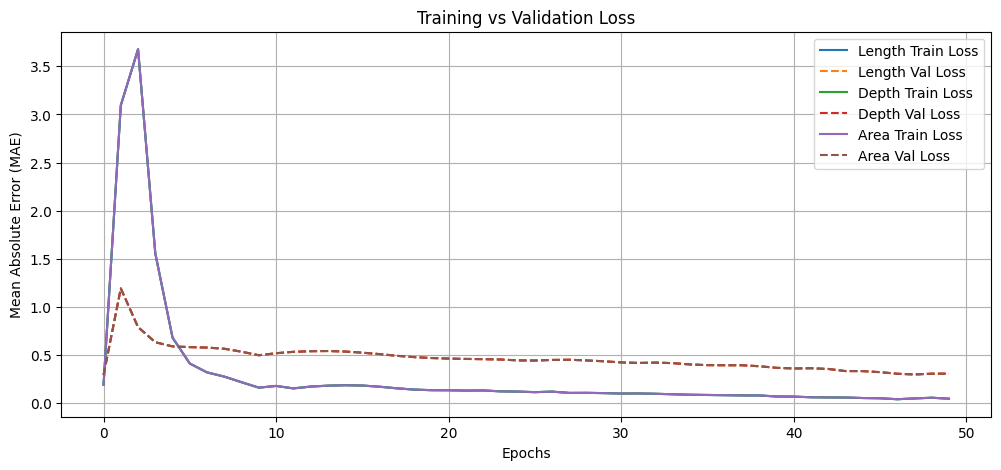

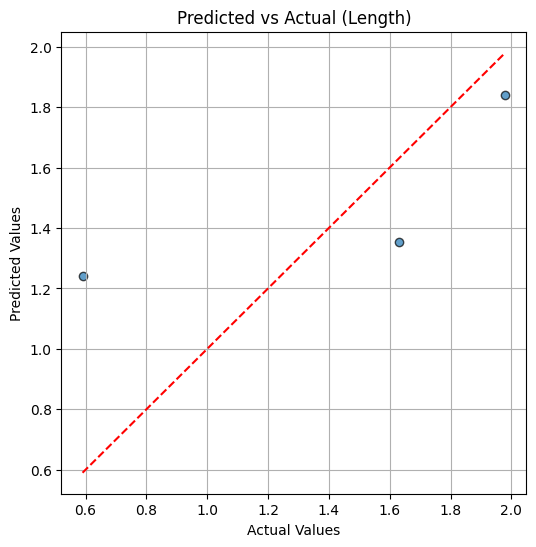

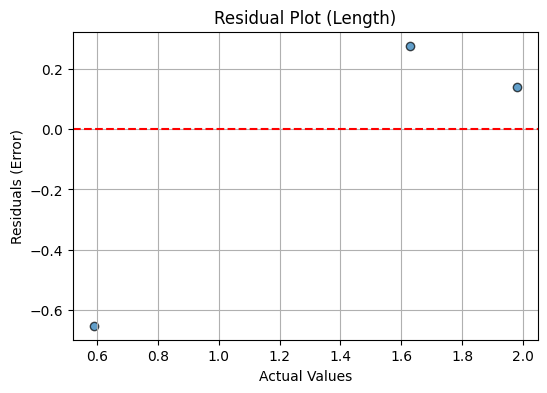

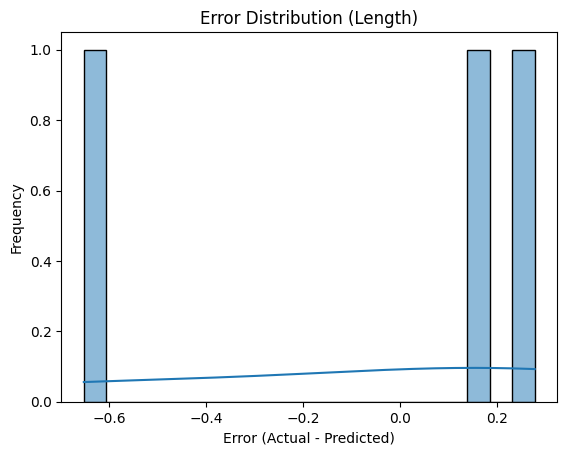

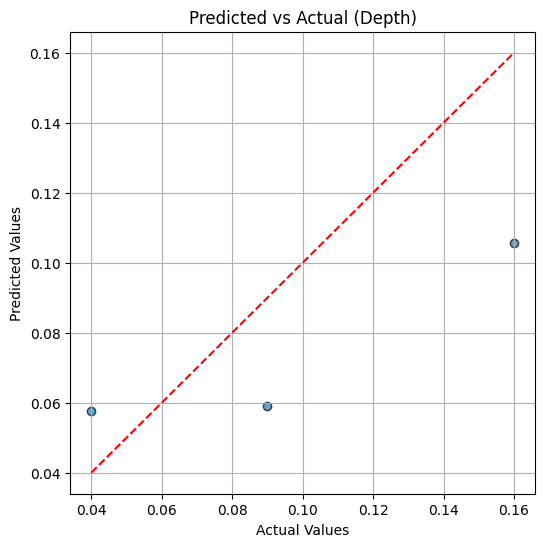

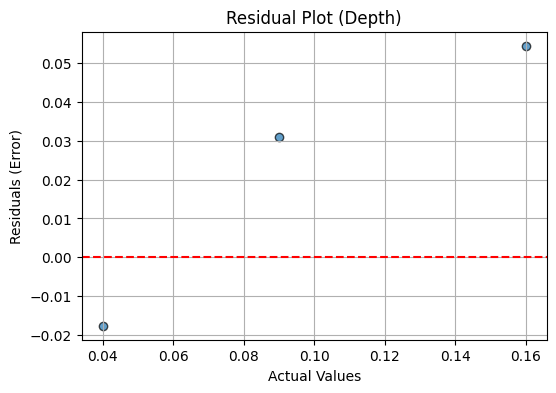

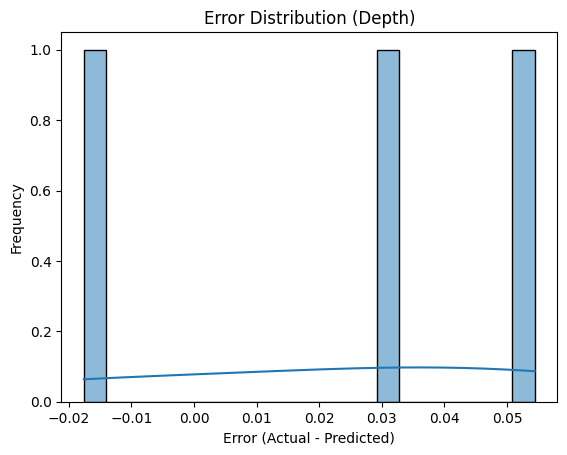

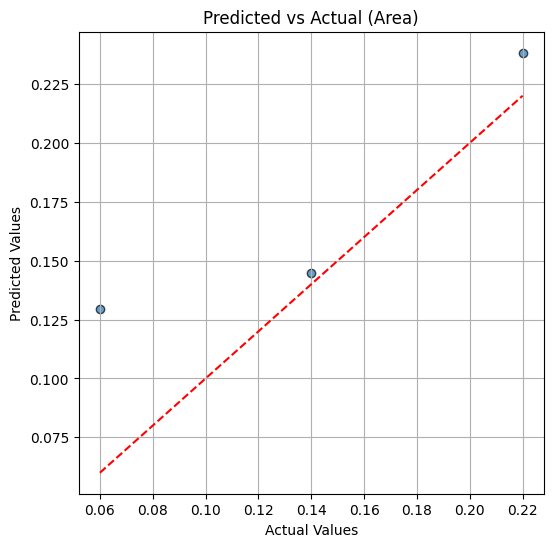

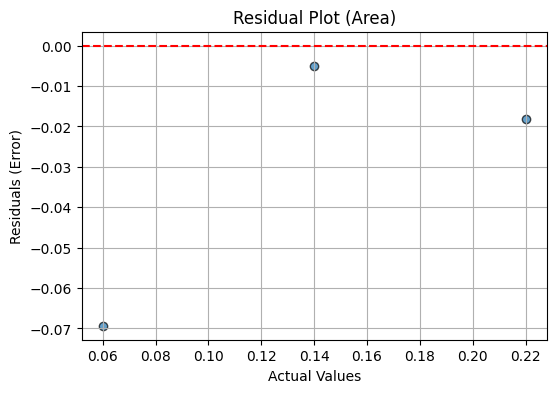

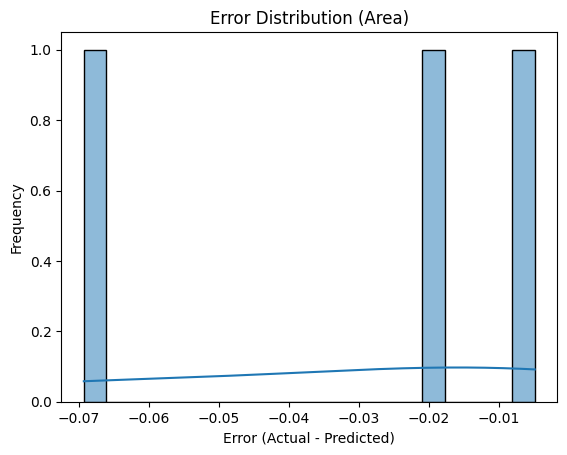

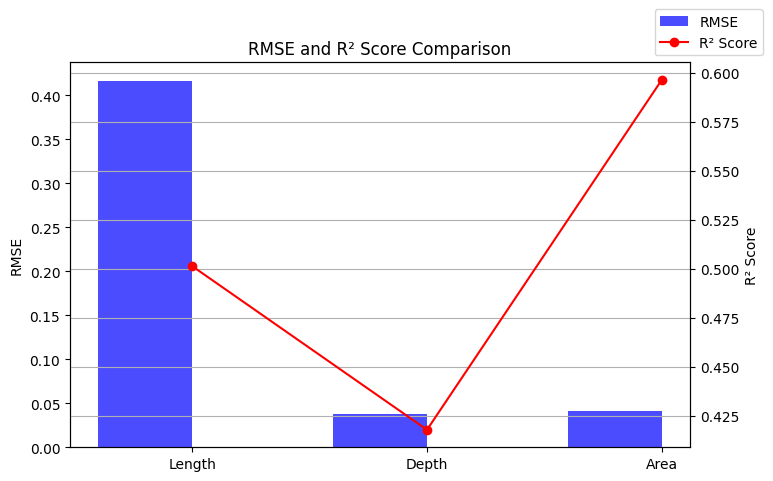

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot training history
def plot_loss_curves(history):
    plt.figure(figsize=(12, 5))

    # Loss for Length, Depth, Area
    for i, label in enumerate(["Length", "Depth", "Area"]):
        plt.plot(history.history[f'length_loss'], label=f"{label} Train Loss")
        plt.plot(history.history[f'val_length_loss'], '--', label=f"{label} Val Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Mean Absolute Error (MAE)")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

# Function to plot Predicted vs Actual Scatter Plot
def plot_scatter(y_test_rescaled, pred_rescaled, name):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_rescaled, pred_rescaled, alpha=0.7, edgecolors='k')
    plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs Actual ({name})")
    plt.grid()
    plt.show()

# Function to plot Residuals
def plot_residuals(y_test_rescaled, pred_rescaled, name):
    residuals = y_test_rescaled - pred_rescaled
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test_rescaled, residuals, alpha=0.7, edgecolors='k')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Actual Values")
    plt.ylabel("Residuals (Error)")
    plt.title(f"Residual Plot ({name})")
    plt.grid()
    plt.show()

# Function to plot Error Distribution
def plot_error_distribution(y_test_rescaled, pred_rescaled, name):
    errors = y_test_rescaled - pred_rescaled
    sns.histplot(errors, bins=20, kde=True)
    plt.xlabel("Error (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.title(f"Error Distribution ({name})")
    plt.show()

# Plot RMSE and R² Scores
def plot_rmse_r2(rmse_values, r2_values):
    labels = ["Length", "Depth", "Area"]
    x = np.arange(len(labels))

    fig, ax1 = plt.subplots(figsize=(8, 5))

    # RMSE bar plot
    ax1.bar(x - 0.2, rmse_values, width=0.4, label="RMSE", color='b', alpha=0.7)
    ax1.set_ylabel("RMSE")
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)

    # R² line plot
    ax2 = ax1.twinx()
    ax2.plot(x, r2_values, 'ro-', label="R² Score")
    ax2.set_ylabel("R² Score")

    fig.legend(loc="upper right", bbox_to_anchor=(1,1))
    plt.title("RMSE and R² Score Comparison")
    plt.grid()
    plt.show()

# 📌 Call Visualization Functions
plot_loss_curves(history)

for i, name in enumerate(["Length", "Depth", "Area"]):
    plot_scatter(y_test_rescaled[:, i], pred_rescaled[:, i], name)
    plot_residuals(y_test_rescaled[:, i], pred_rescaled[:, i], name)
    plot_error_distribution(y_test_rescaled[:, i], pred_rescaled[:, i], name)

plot_rmse_r2(
    [np.sqrt(mean_squared_error(y_test_rescaled[:, i], pred_rescaled[:, i])) for i in range(3)],
    [r2_score(y_test_rescaled[:, i], pred_rescaled[:, i]) for i in range(3)]
)


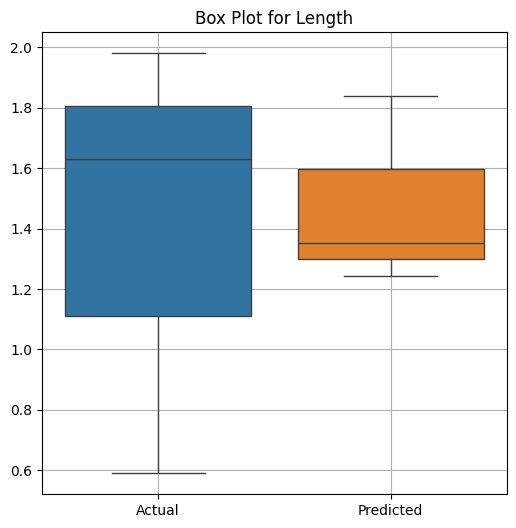

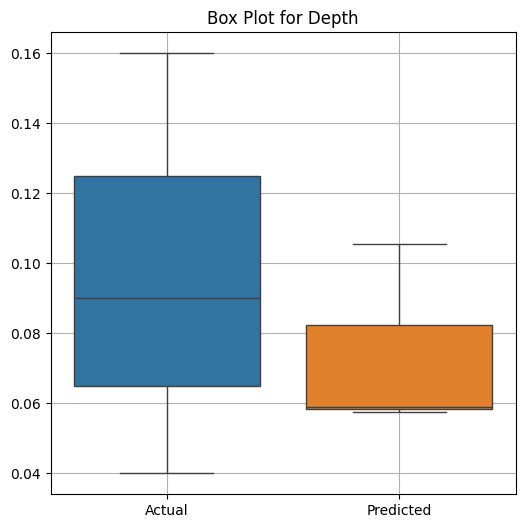

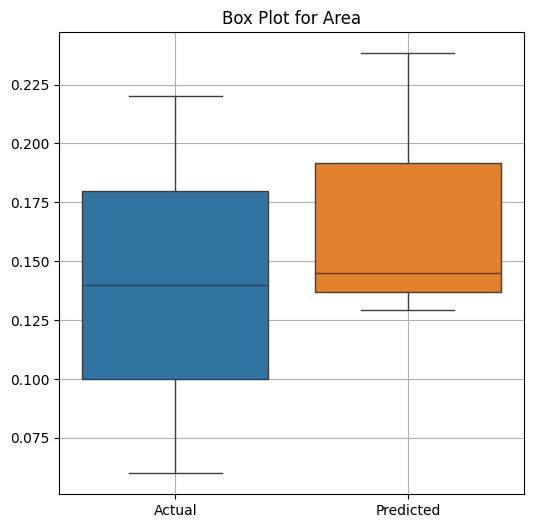

In [ ]:
# Define function for box plots
def box_plot(y_actual, y_pred, title):
    df = pd.DataFrame({"Actual": y_actual, "Predicted": y_pred})
    plt.figure(figsize=(6, 6))
    sns.boxplot(data=df)
    plt.title(title)
    plt.grid()
    plt.show()

# Box plots for each target variable
box_plot(y_test_rescaled[:, 0], pred_rescaled[:, 0], "Box Plot for Length")
box_plot(y_test_rescaled[:, 1], pred_rescaled[:, 1], "Box Plot for Depth")
box_plot(y_test_rescaled[:, 2], pred_rescaled[:, 2], "Box Plot for Area")


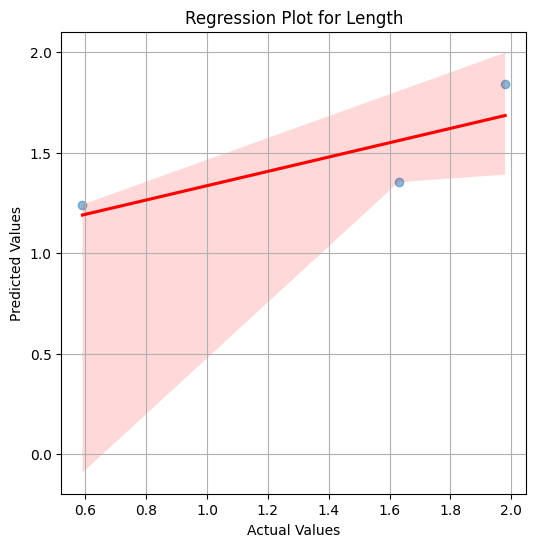

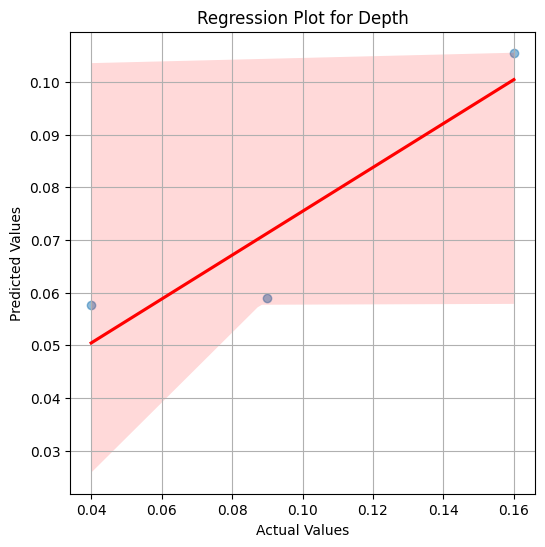

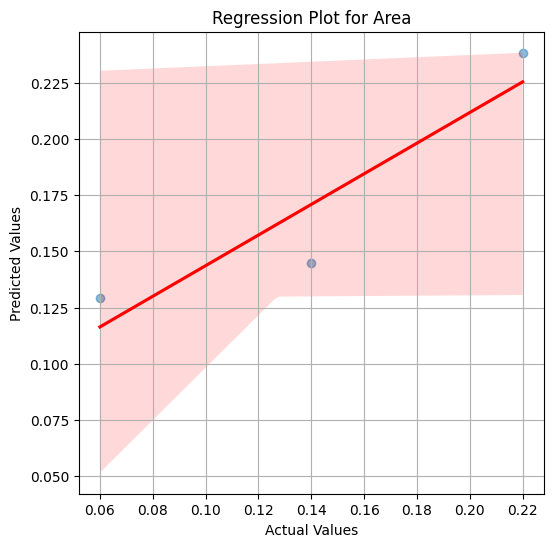

In [ ]:
# Define function for regression plots
def regression_plot(y_actual, y_pred, title):
    plt.figure(figsize=(6, 6))
    sns.regplot(x=y_actual, y=y_pred, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.grid()
    plt.show()

# Regression plots for each target variable
regression_plot(y_test_rescaled[:, 0], pred_rescaled[:, 0], "Regression Plot for Length")
regression_plot(y_test_rescaled[:, 1], pred_rescaled[:, 1], "Regression Plot for Depth")
regression_plot(y_test_rescaled[:, 2], pred_rescaled[:, 2], "Regression Plot for Area")


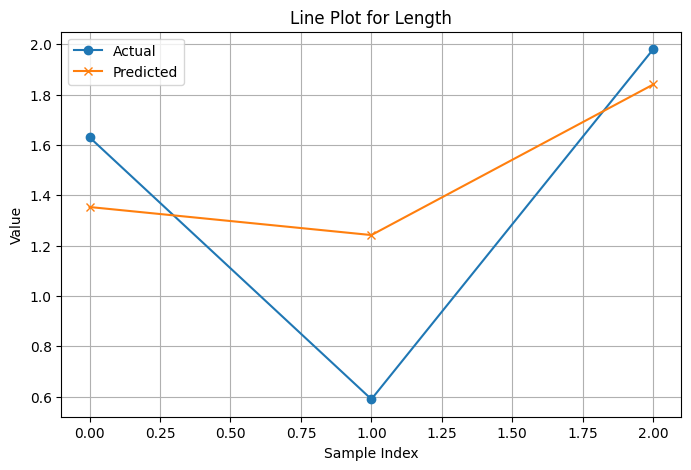

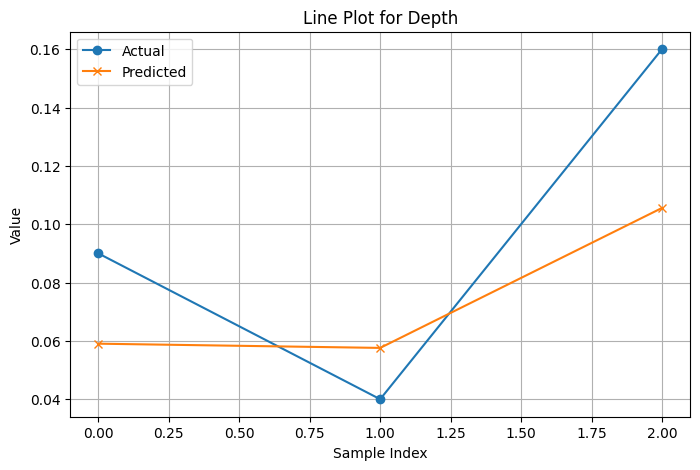

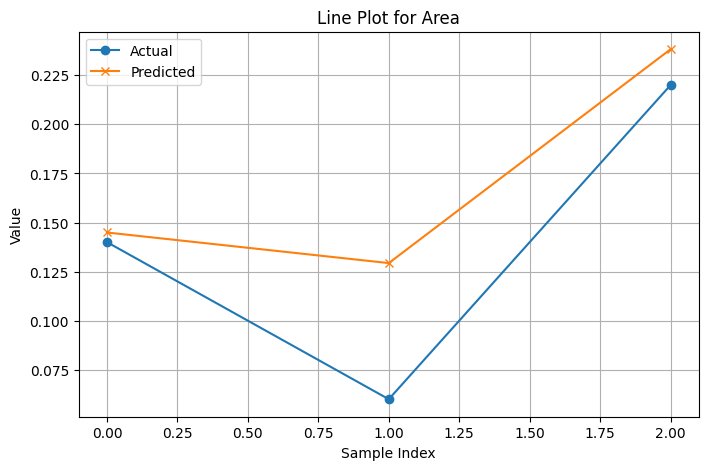

In [ ]:
# Define function for line plots
def line_plot(y_actual, y_pred, title):
    plt.figure(figsize=(8, 5))
    plt.plot(y_actual, label="Actual", marker='o')
    plt.plot(y_pred, label="Predicted", marker='x')
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Line plots for each target variable
line_plot(y_test_rescaled[:, 0], pred_rescaled[:, 0], "Line Plot for Length")
line_plot(y_test_rescaled[:, 1], pred_rescaled[:, 1], "Line Plot for Depth")
line_plot(y_test_rescaled[:, 2], pred_rescaled[:, 2], "Line Plot for Area")


EfficientNetB0 + Numerical Inputs → Multi-Output Regression

5/4/25(upto now best)

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load Excel Data
excel_file = "/content/drive/MyDrive/Tool_wear___1.xlsx"
data = pd.read_excel(excel_file)

spindle_speed = data["Spindle speed (rpm)"].values
feed_rate = data["Feed/rev (mm/rev)"].values
depth = data["depth (mm)"].values
length = data["length (mm)"].values
area = data["Area (sq mm)"].values
image_numbers = data["image"].values

# Load and preprocess images
image_folder = "/content/drive/MyDrive/Images"
image_data = []
valid_indices = []

for i, img_number in enumerate(image_numbers):
    img_path = os.path.join(image_folder, f"{img_number}.jpg")
    if os.path.exists(img_path):
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        image_data.append(img_array)
        valid_indices.append(i)
    else:
        print(f"Missing image: {img_number}.jpg")

# Filter arrays by valid indices
spindle_speed = spindle_speed[valid_indices]
feed_rate = feed_rate[valid_indices]
length = length[valid_indices]
depth = depth[valid_indices]
area = area[valid_indices]
image_data = np.array(image_data)

# Combine & scale numerical input
numerical_inputs = np.column_stack((spindle_speed, feed_rate))
num_scaler = MinMaxScaler()
numerical_inputs_scaled = num_scaler.fit_transform(numerical_inputs)
joblib.dump(num_scaler, "numerical_scaler.pkl")

# Scale targets
targets = np.column_stack((length, depth, area))
target_scaler = MinMaxScaler()
targets_scaled = target_scaler.fit_transform(targets)
joblib.dump(target_scaler, "target_scaler.pkl")

# Train-test split
X_img_train, X_img_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    image_data, numerical_inputs_scaled, targets_scaled, test_size=0.2, random_state=42
)

# EfficientNetB0 backbone
effnet = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
effnet.trainable = False

# Image input
img_input = Input(shape=(224, 224, 3))
x = effnet(img_input)
x = GlobalAveragePooling2D()(x)

# Numerical input
num_input = Input(shape=(X_num_train.shape[1],))
num_dense = Dense(32, activation='relu')(num_input)

# Combine image + numeric features
combined = Concatenate()([x, num_dense])
fc = Dense(128, activation='relu')(combined)
fc = Dropout(0.3)(fc)
fc = Dense(64, activation='relu')(fc)
fc = Dropout(0.2)(fc)

# Outputs
out_length = Dense(1, name='length')(fc)
out_depth = Dense(1, name='depth')(fc)
out_area = Dense(1, name='area')(fc)

# Model definition
model = Model(inputs=[img_input, num_input], outputs=[out_length, out_depth, out_area])
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=['mae', 'mae', 'mae'],  # one loss for each output
    metrics=[['mae'], ['mae'], ['mae']]  # one metric for each output
)

model.summary()

# Train model
history = model.fit(
    [X_img_train, X_num_train],
    [y_train[:, 0], y_train[:, 1], y_train[:, 2]],
    validation_split=0.2,
    epochs=50,
    batch_size=4,
    verbose=1
)

# Evaluate model
results = model.evaluate(
    [X_img_test, X_num_test],
    [y_test[:, 0], y_test[:, 1], y_test[:, 2]]
)

# Predict
predictions = model.predict([X_img_test, X_num_test])

# Inverse scale predictions
pred_rescaled = target_scaler.inverse_transform(np.column_stack(predictions))
y_test_rescaled = target_scaler.inverse_transform(y_test)

# RMSE and R² Scores
print("\n🔹 RMSE and R² Scores 🔹")
for i, name in enumerate(['Length', 'Depth', 'Area']):
    rmse = np.sqrt(mean_squared_error(y_test_rescaled[:, i], pred_rescaled[:, i]))
    r2 = r2_score(y_test_rescaled[:, i], pred_rescaled[:, i])
    print(f"{name} RMSE: {rmse:.3f}, R²: {r2:.3f}")

# Sample predictions
print("\n🔹 Predicted vs Actual Values 🔹")
for i in range(len(pred_rescaled)):
    print(f"Predicted Length: {pred_rescaled[i][0]:.4f}, Actual Length: {y_test_rescaled[i][0]:.4f}")
    print(f"Predicted Depth : {pred_rescaled[i][1]:.4f}, Actual Depth : {y_test_rescaled[i][1]:.4f}")
    print(f"Predicted Area  : {pred_rescaled[i][2]:.4f}, Actual Area  : {y_test_rescaled[i][2]:.4f}\n")


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 7, 7, 1280)     │      4,049,571 │ input_layer_10[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1280)           │              0 │ efficientnetb0[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 32)             │             96 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 1312)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 128)            │        168,064 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 128)            │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 64)             │          8,256 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 64)             │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ length (Dense)            │ (None, 1)              │             65 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depth (Dense)             │ (None, 1)              │             65 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area (Dense)              │ (None, 1)              │             65 │ dropout_10[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,226,182 (16.12 MB)

 Trainable params: 176,611 (689.89 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - area_loss: 0.4026 - area_mae: 0.4026 - depth_loss: 0.4962 - depth_mae: 0.4962 - length_loss: 0.3443 - length_mae: 0.3443 - loss: 1.2431 - val_area_loss: 0.6503 - val_area_mae: 0.6503 - val_depth_loss: 0.3874 - val_depth_mae: 0.3874 - val_length_loss: 0.6458 - val_length_mae: 0.6458 - val_loss: 1.6836
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 496ms/step - area_loss: 0.4591 - area_mae: 0.4591 - depth_loss: 0.5908 - depth_mae: 0.5908 - length_loss: 0.4678 - length_mae: 0.4678 - loss: 1.5176 - val_area_loss: 0.8987 - val_area_mae: 0.8987 - val_depth_loss: 0.3935 - val_depth_mae: 0.3935 - val_length_loss: 0.3062 - val_length_mae: 0.3062 - val_loss: 1.5984
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 488ms/step - area_loss: 0.2788 - area_mae: 0.2788 - depth_loss: 0.3018 - depth_mae: 0.3018 - length_loss: 0.3758 - length_mae: 0.3758 - loss: 0.9565 - val_area_loss: 0.8609 - val_area_mae: 0.8609 - val_depth_loss: 0.4204 - val_depth_mae: 0.4204 - val_leng

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

🔹 RMSE and R² Scores 🔹
Length RMSE: 0.407, R²: 0.526
Depth RMSE: 0.032, R²: 0.566
Area RMSE: 0.034, R²: 0.733

🔹 Predicted vs Actual Values 🔹
Predicted Length: 1.8797, Actual Length: 1.6300
Predicted Depth : 0.1027, Actual Depth : 0.0900
Predicted Area  : 0.1849, Actual Area  : 0.1400

Predicted Length: 0.9612, Actual Length: 0.5900
Predicted Depth : 0.0756, Actual Depth : 0.0400
Predicted Area  : 0.0803, Actual Area  : 0.0600

Predicted Length: 1.4363, Actual Length: 1.9800
Predicted Depth : 0.1185, Actual Depth : 0.1600
Predicted Area  : 0.1887, Actual Area  : 0.2200




12-04
> Add blockquote



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
data = {
    "spindle_speed": [1000, 1000, 1100, 12000, 1100, 12000, 1100, 12000, 1000, 14000, 1000, 12000, 1100, 14000],
    "feed_rate": [0.3, 0.1, 0.1, 0.4, 0.3, 0.3, 0.4, 0.2, 0.4, 0.1, 0.2, 0.1, 0.2, 0.2],
    "filename": [f"{i}.jpg" for i in [0, 2, 5, 6, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19]],
    "depth": [0.12, 0.04, 0.05, 0.28, 0.18, 0.2, 0.22, 0.14, 0.16, 0.06, 0.08, 0.05, 0.1, 0.11],
    "length": [1.6, 0.9, 1.0, 3.2, 2.4, 2.6, 2.8, 1.9, 2.2, 1.1, 1.4, 1.0, 1.5, 1.8],
    "area": [0.192, 0.036, 0.05, 0.896, 0.432, 0.52, 0.616, 0.266, 0.352, 0.066, 0.112, 0.05, 0.15, 0.198]
}

df = pd.DataFrame(data)

# Preprocess numerical data
scaler = StandardScaler()
numerical_data = scaler.fit_transform(df[["spindle_speed", "feed_rate"]])
targets = np.column_stack([df["depth"], df["length"], df["area"]])

# Load and preprocess original images
original_images = np.array([
    preprocess_input(image.img_to_array(image.load_img(f"/content/drive/MyDrive/Images/{fname}", target_size=(224, 224))))
    for fname in df["filename"]
])

# Data augmentation
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1,
                             height_shift_range=0.1, horizontal_flip=True)

augmented_images = []
augmented_numerical = []
augmented_targets = []

for img, num, tgt in zip(original_images, numerical_data, targets):
    img = np.expand_dims(img, 0)
    gen = datagen.flow(img, batch_size=1)
    for _ in range(3):  # 3 augmentations per image
        aug_img = gen.__next__()[0]
        augmented_images.append(aug_img)
        augmented_numerical.append(num)
        augmented_targets.append(tgt)

# Combine original and augmented data
all_images = np.concatenate([original_images, np.array(augmented_images)])
all_numerical = np.concatenate([numerical_data, np.array(augmented_numerical)])
all_targets = np.concatenate([targets, np.array(augmented_targets)])

# Train-test split
X_img_train, X_img_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    all_images, all_numerical, all_targets, test_size=0.2, random_state=42
)

# Define the image model (EfficientNetB0)
img_input = Input(shape=(224, 224, 3))
base_model = EfficientNetB0(include_top=False, input_tensor=img_input, pooling='avg')
img_features = base_model.output

# Define the numerical model (BiGRU + Transformer-style)
num_input = Input(shape=(2,))
x = layers.Dense(64, activation='relu')(num_input)
x = layers.RepeatVector(1)(x)
x = layers.Bidirectional(layers.GRU(32, return_sequences=True))(x)
attn_output = layers.MultiHeadAttention(num_heads=2, key_dim=16)(x, x)
attn_output = layers.GlobalAveragePooling1D()(attn_output)

# Concatenate both
combined = layers.Concatenate()([img_features, attn_output])
x = layers.Dense(128, activation='relu')(combined)
x = layers.Dropout(0.3)(x)

# Multi-output heads
depth_output = layers.Dense(1, name='depth')(x)
length_output = layers.Dense(1, name='length')(x)
area_output = layers.Dense(1, name='area')(x)

model = Model(inputs=[img_input, num_input], outputs=[depth_output, length_output, area_output])
model.compile(
    optimizer='adam',
    loss=['mse', 'mse', 'mse'],
    loss_weights=[1.5, 1.0, 1.0],  # prioritize improving depth a bit more
    metrics=['mae', 'mae', 'mae']
)

# Train model
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    [X_img_train, X_num_train], [y_train[:, 0], y_train[:, 1], y_train[:, 2]],
    validation_split=0.2,
    epochs=100,
    batch_size=8,
    callbacks=[early_stop],
    verbose=2
)

# Evaluate
loss, depth_loss, length_loss, area_loss, depth_mae, length_mae, area_mae = model.evaluate([X_img_test, X_num_test],
                                                                                           [y_test[:, 0], y_test[:, 1], y_test[:, 2]])
print(f"\nTest Loss: {loss:.4f}")
print(f"Test MAE (Depth): {depth_mae:.4f}")
print(f"Test MAE (Length): {length_mae:.4f}")
print(f"Test MAE (Area): {area_mae:.4f}")

# Predictions and R² Score
y_pred = model.predict([X_img_test, X_num_test])
depth_r2 = r2_score(y_test[:, 0], y_pred[0])
length_r2 = r2_score(y_test[:, 1], y_pred[1])
area_r2 = r2_score(y_test[:, 2], y_pred[2])

print(f"\nR² Score (Depth):  {depth_r2:.4f}")
print(f"R² Score (Length): {length_r2:.4f}")
print(f"R² Score (Area):   {area_r2:.4f}")


Epoch 1/100
5/5 - 52s - 10s/step - area_loss: 0.3106 - area_mae: 0.4112 - depth_loss: 0.1250 - depth_mae: 0.2701 - length_loss: 1.5138 - length_mae: 0.8791 - loss: 1.7998 - val_area_loss: 0.1631 - val_area_mae: 0.3258 - val_depth_loss: 0.0505 - val_depth_mae: 0.2202 - val_length_loss: 0.4133 - val_length_mae: 0.4041 - val_loss: 0.6111
Epoch 2/100
5/5 - 1s - 144ms/step - area_loss: 0.5243 - area_mae: 0.5360 - depth_loss: 0.3100 - depth_mae: 0.4468 - length_loss: 1.7988 - length_mae: 1.0361 - loss: 2.9260 - val_area_loss: 0.1118 - val_area_mae: 0.3050 - val_depth_loss: 0.0529 - val_depth_mae: 0.2621 - val_length_loss: 1.0534 - val_length_mae: 0.6898 - val_loss: 0.9964
Epoch 3/100
5/5 - 1s - 134ms/step - area_loss: 0.1542 - area_mae: 0.3154 - depth_loss: 0.1579 - depth_mae: 0.3330 - length_loss: 2.0728 - length_mae: 1.1375 - loss: 2.2972 - val_area_loss: 0.0303 - val_area_mae: 0.1730 - val_depth_loss: 0.0267 - val_depth_mae: 0.1687 - val_length_loss: 0.9399 - val_length_mae: 0.6819 - val_

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import math

# Load the dataset
data = {
    "spindle_speed": [1000, 1000, 1100, 12000, 1100, 12000, 1100, 12000, 1000, 14000, 1000, 12000, 1100, 14000],
    "feed_rate": [0.3, 0.1, 0.1, 0.4, 0.3, 0.3, 0.4, 0.2, 0.4, 0.1, 0.2, 0.1, 0.2, 0.2],
    "filename": [f"{i}.jpg" for i in [0, 2, 5, 6, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19]],
    "depth": [0.12, 0.04, 0.05, 0.28, 0.18, 0.2, 0.22, 0.14, 0.16, 0.06, 0.08, 0.05, 0.1, 0.11],
    "length": [1.6, 0.9, 1.0, 3.2, 2.4, 2.6, 2.8, 1.9, 2.2, 1.1, 1.4, 1.0, 1.5, 1.8],
    "area": [0.192, 0.036, 0.05, 0.896, 0.432, 0.52, 0.616, 0.266, 0.352, 0.066, 0.112, 0.05, 0.15, 0.198]
}

df = pd.DataFrame(data)

# Preprocess numerical data
scaler = StandardScaler()
numerical_data = scaler.fit_transform(df[["spindle_speed", "feed_rate"]])
targets = np.column_stack([df["depth"], df["length"], df["area"]])

# Apply log transformation to depth
depth_transformed = np.log1p(df["depth"])

# Load and preprocess images
original_images = np.array([
    preprocess_input(image.img_to_array(image.load_img(f"/content/drive/MyDrive/Images/{fname}", target_size=(224, 224))))
    for fname in df["filename"]
])

# Data augmentation
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

augmented_images, augmented_numerical, augmented_targets = [], [], []
for img, num, tgt in zip(original_images, numerical_data, targets):
    img = np.expand_dims(img, 0)
    gen = datagen.flow(img, batch_size=1, shuffle=False)
    for _ in range(3):
        aug_img = gen.__next__()[0]
        augmented_images.append(aug_img)
        augmented_numerical.append(num)
        augmented_targets.append(tgt)

all_images = np.concatenate([original_images, np.array(augmented_images)])
all_numerical = np.concatenate([numerical_data, np.array(augmented_numerical)])
all_targets = np.concatenate([targets, np.array(augmented_targets)])

# Train-test split
X_img_train, X_img_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    all_images, all_numerical, all_targets, test_size=0.2, random_state=42
)

# Cosine Annealing LR
def cosine_annealing(epoch, lr):
    max_lr = 1e-2  # Increased max_lr for faster convergence
    min_lr = 1e-5
    return min_lr + (max_lr - min_lr) * (1 + math.cos(math.pi * epoch / 100)) / 2

cosine_callback = LearningRateScheduler(cosine_annealing)

# Image model
img_input = Input(shape=(224, 224, 3))
base_model = EfficientNetB0(include_top=False, input_tensor=img_input, pooling='avg')

# Fine-tune last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

img_features = base_model.output

# Numerical model
num_input = Input(shape=(2,))
x = layers.Dense(64, activation='relu')(num_input)
x = layers.RepeatVector(1)(x)
x = layers.Bidirectional(layers.GRU(32, return_sequences=True))(x)
attn_output = layers.MultiHeadAttention(num_heads=2, key_dim=16)(x, x)
attn_output = layers.GlobalAveragePooling1D()(attn_output)

# Added Dense layer for more complexity
x = layers.Dense(128, activation='relu')(attn_output)

# Fuse features
combined = layers.Concatenate()([img_features, x])
x = layers.Dense(128, activation='relu')(combined)
x = layers.Dropout(0.3)(x)

# Output heads
depth_output = layers.Dense(1, name='depth')(x)
length_output = layers.Dense(1, name='length')(x)
area_output = layers.Dense(1, name='area')(x)

model = Model(inputs=[img_input, num_input], outputs=[depth_output, length_output, area_output])
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=['mse', 'mse', 'mse'],
    loss_weights=[2.0, 1.0, 1.2],  # Boost Depth weight further
    metrics=['mae', 'mae', 'mae']
)

# Train
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    [X_img_train, X_num_train], [np.log1p(y_train[:, 0]), y_train[:, 1], y_train[:, 2]],  # Apply log to depth during training
    validation_split=0.2,
    epochs=100,
    batch_size=8,
    callbacks=[early_stop, cosine_callback],
    verbose=2
)

# Evaluate
loss, depth_loss, length_loss, area_loss, depth_mae, length_mae, area_mae = model.evaluate(
    [X_img_test, X_num_test], [np.log1p(y_test[:, 0]), y_test[:, 1], y_test[:, 2]]  # Apply log to depth during testing
)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test MAE (Depth): {depth_mae:.4f}")
print(f"Test MAE (Length): {length_mae:.4f}")
print(f"Test MAE (Area): {area_mae:.4f}")

# Predict once to avoid retracing warning
y_pred = model.predict([X_img_test, X_num_test], verbose=0)

# Inverse transform depth predictions
y_pred[0] = np.expm1(y_pred[0])  # Inverse log transformation for depth

depth_r2 = r2_score(np.expm1(y_test[:, 0]), y_pred[0])  # Inverse log transformation for ground truth depth
length_r2 = r2_score(y_test[:, 1], y_pred[1])
area_r2 = r2_score(y_test[:, 2], y_pred[2])

print(f"\nR² Score (Depth):  {depth_r2:.4f}")
print(f"R² Score (Length): {length_r2:.4f}")
print(f"R² Score (Area):   {area_r2:.4f}")


Epoch 1/100
5/5 - 33s - 7s/step - area_loss: 2.0371 - area_mae: 1.0012 - depth_loss: 0.8715 - depth_mae: 0.7448 - length_loss: 11.7742 - length_mae: 2.4858 - loss: 17.6192 - val_area_loss: 2.2286 - val_area_mae: 1.2253 - val_depth_loss: 167.5809 - val_depth_mae: 6.9522 - val_length_loss: 32.9749 - val_length_mae: 4.9517 - val_loss: 215.5595 - learning_rate: 0.0100
Epoch 2/100
5/5 - 0s - 67ms/step - area_loss: 0.7724 - area_mae: 0.7205 - depth_loss: 1.4718 - depth_mae: 0.7812 - length_loss: 3.4638 - length_mae: 1.5077 - loss: 8.1970 - val_area_loss: 48.9464 - val_area_mae: 4.4701 - val_depth_loss: 396.7457 - val_depth_mae: 17.2295 - val_length_loss: 116.2625 - val_length_mae: 11.8233 - val_loss: 985.5427 - learning_rate: 0.0100
Epoch 3/100
5/5 - 1s - 115ms/step - area_loss: 0.3232 - area_mae: 0.4646 - depth_loss: 0.5511 - depth_mae: 0.5479 - length_loss: 2.2688 - length_mae: 1.3159 - loss: 4.0883 - val_area_loss: 831.8765 - val_area_mae: 25.0149 - val_depth_loss: 346.4851 - val_depth_ma

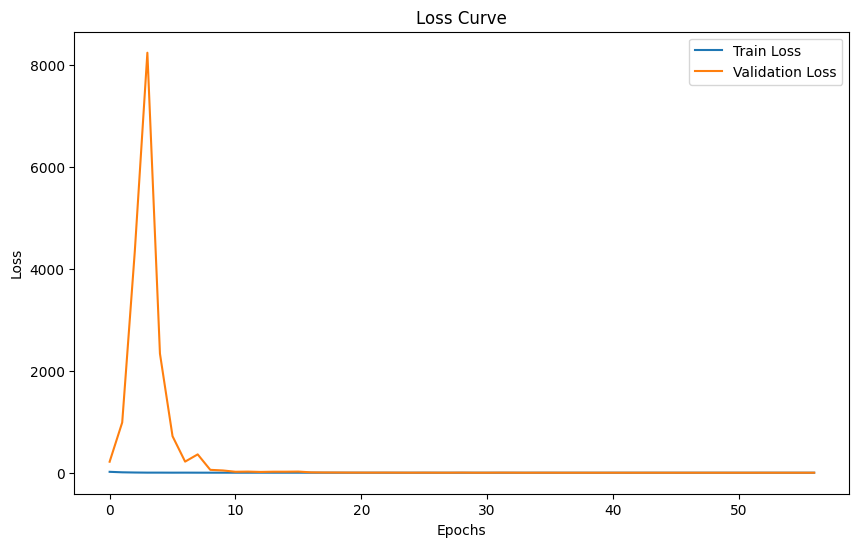

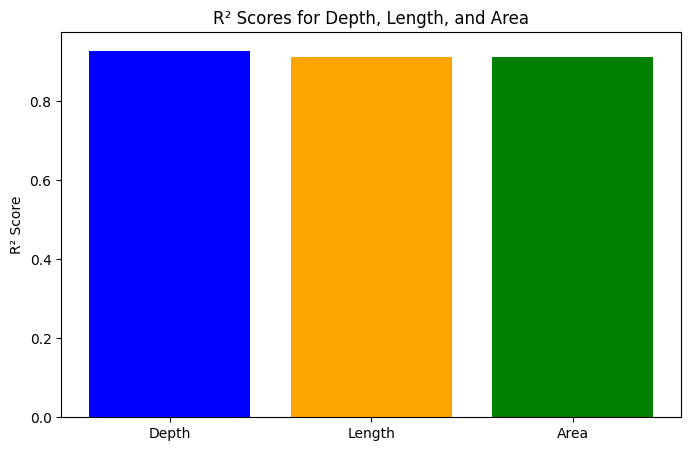

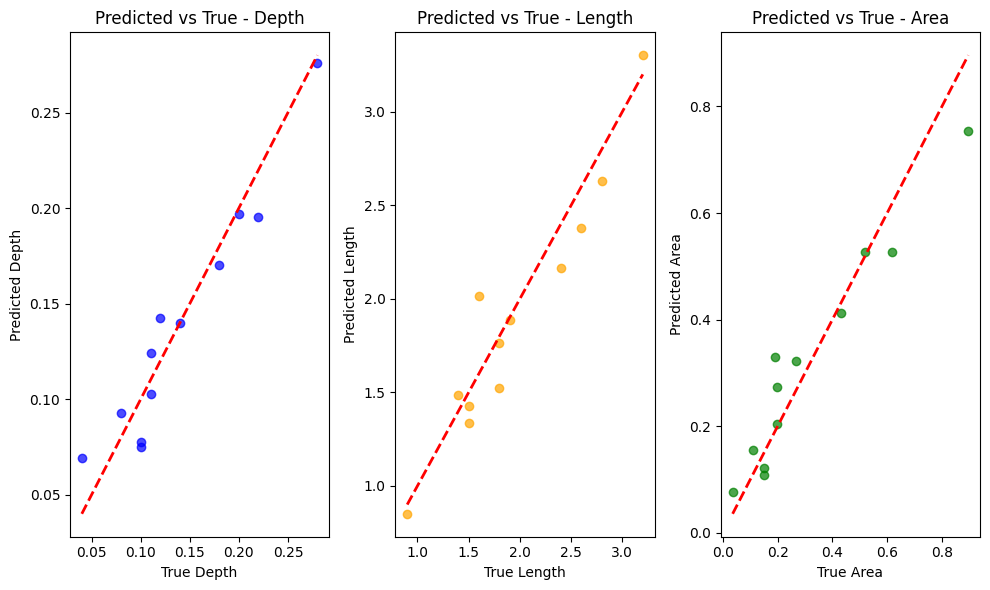

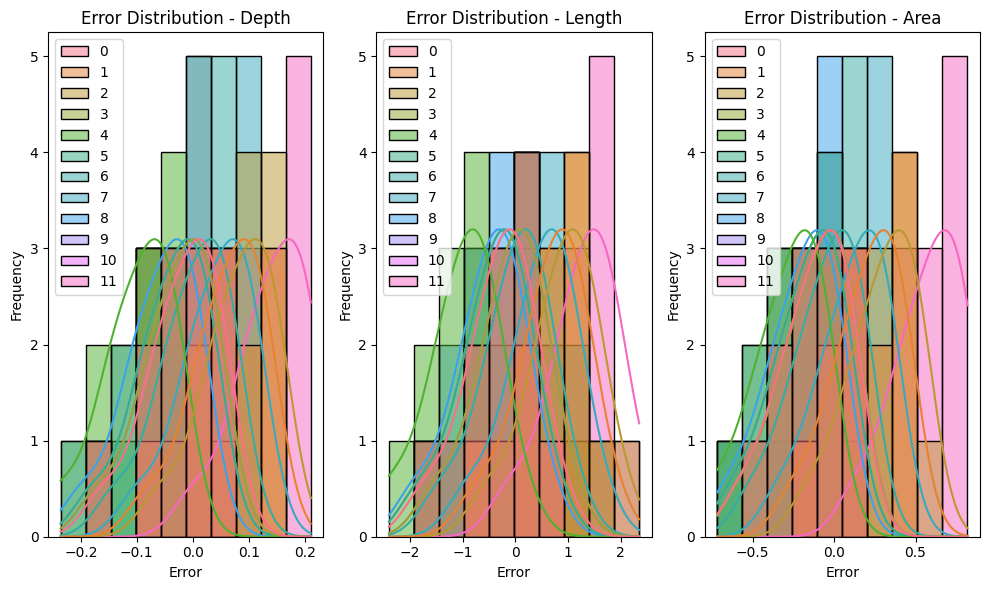

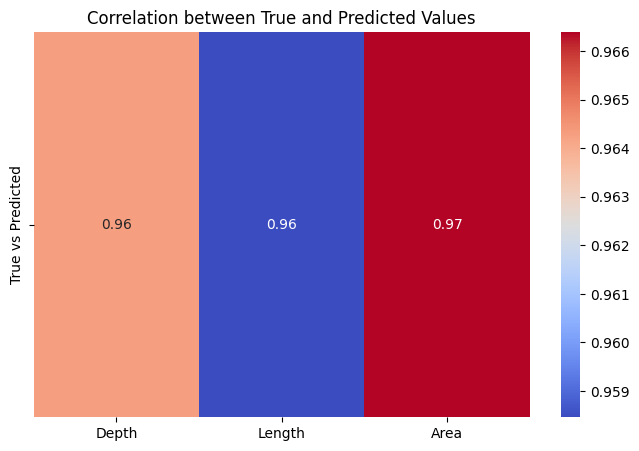

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualize Loss Curve
def plot_loss_curve(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Visualize R² Scores
def plot_r2_scores(y_true, y_pred):
    depth_r2 = r2_score(y_true[:, 0], y_pred[0])
    length_r2 = r2_score(y_true[:, 1], y_pred[1])
    area_r2 = r2_score(y_true[:, 2], y_pred[2])

    r2_scores = {'Depth': depth_r2, 'Length': length_r2, 'Area': area_r2}
    plt.figure(figsize=(8, 5))
    plt.bar(r2_scores.keys(), r2_scores.values(), color=['blue', 'orange', 'green'])
    plt.title('R² Scores for Depth, Length, and Area')
    plt.ylabel('R² Score')
    plt.show()

# Visualize Predicted vs True Values
def plot_pred_vs_true(y_true, y_pred):
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 3, 1)
    plt.scatter(y_true[:, 0], y_pred[0], color='blue', alpha=0.7)
    plt.plot([y_true[:, 0].min(), y_true[:, 0].max()], [y_true[:, 0].min(), y_true[:, 0].max()], 'r--', lw=2)
    plt.title('Predicted vs True - Depth')
    plt.xlabel('True Depth')
    plt.ylabel('Predicted Depth')

    plt.subplot(1, 3, 2)
    plt.scatter(y_true[:, 1], y_pred[1], color='orange', alpha=0.7)
    plt.plot([y_true[:, 1].min(), y_true[:, 1].max()], [y_true[:, 1].min(), y_true[:, 1].max()], 'r--', lw=2)
    plt.title('Predicted vs True - Length')
    plt.xlabel('True Length')
    plt.ylabel('Predicted Length')

    plt.subplot(1, 3, 3)
    plt.scatter(y_true[:, 2], y_pred[2], color='green', alpha=0.7)
    plt.plot([y_true[:, 2].min(), y_true[:, 2].max()], [y_true[:, 2].min(), y_true[:, 2].max()], 'r--', lw=2)
    plt.title('Predicted vs True - Area')
    plt.xlabel('True Area')
    plt.ylabel('Predicted Area')

    plt.tight_layout()
    plt.show()

# Visualize Error Distribution
def plot_error_distribution(y_true, y_pred):
    depth_error = y_true[:, 0] - y_pred[0]
    length_error = y_true[:, 1] - y_pred[1]
    area_error = y_true[:, 2] - y_pred[2]

    plt.figure(figsize=(10, 6))

    plt.subplot(1, 3, 1)
    sns.histplot(depth_error, kde=True, color='blue', bins=10)
    plt.title('Error Distribution - Depth')
    plt.xlabel('Error')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    sns.histplot(length_error, kde=True, color='orange', bins=10)
    plt.title('Error Distribution - Length')
    plt.xlabel('Error')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    sns.histplot(area_error, kde=True, color='green', bins=10)
    plt.title('Error Distribution - Area')
    plt.xlabel('Error')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Visualize Correlation of True vs Predicted
def plot_correlation(y_true, y_pred):
    # Flattening the arrays to 1D
    depth_true = y_true[:, 0].flatten()
    length_true = y_true[:, 1].flatten()
    area_true = y_true[:, 2].flatten()

    depth_pred = y_pred[0].flatten()
    length_pred = y_pred[1].flatten()
    area_pred = y_pred[2].flatten()

    # Calculate correlations
    depth_corr = np.corrcoef(depth_true, depth_pred)[0, 1]
    length_corr = np.corrcoef(length_true, length_pred)[0, 1]
    area_corr = np.corrcoef(area_true, area_pred)[0, 1]

    correlation = {'Depth': depth_corr, 'Length': length_corr, 'Area': area_corr}

    # Visualizing correlation as a heatmap
    plt.figure(figsize=(8, 5))
    sns.heatmap([[correlation['Depth'], correlation['Length'], correlation['Area']]], annot=True, cmap='coolwarm',
                xticklabels=['Depth', 'Length', 'Area'], yticklabels=['True vs Predicted'])
    plt.title('Correlation between True and Predicted Values')
    plt.show()

# Call the functions for visualization
plot_loss_curve(history)
plot_r2_scores(y_test, y_pred)
plot_pred_vs_true(y_test, y_pred)
plot_error_distribution(y_test, y_pred)
plot_correlation(y_test, y_pred)


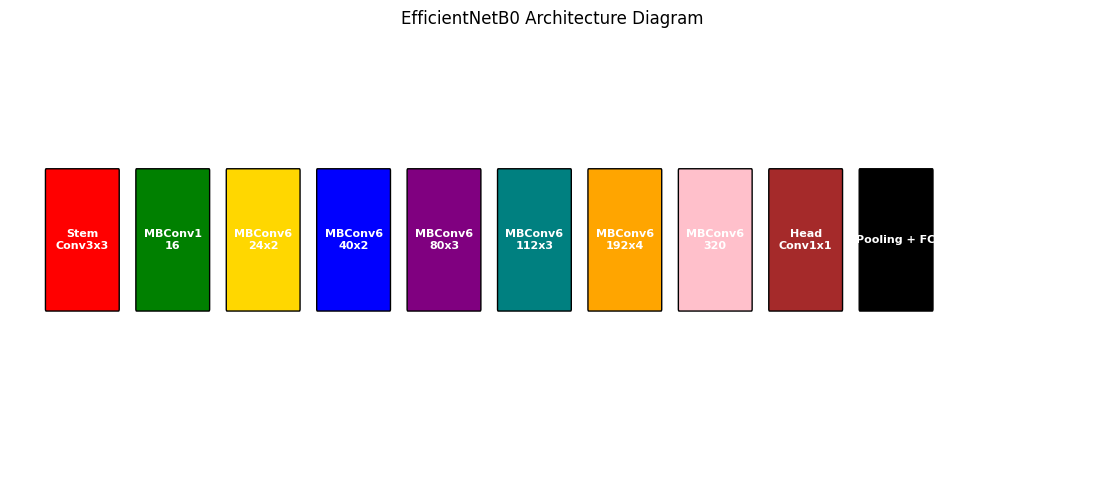

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def add_block(ax, x, y, width, height, label, color):
    rect = patches.FancyBboxPatch((x, y), width, height,
                                  boxstyle="round,pad=0.02",
                                  linewidth=1, edgecolor='black', facecolor=color)
    ax.add_patch(rect)
    ax.text(x + width / 2, y + height / 2, label,
            ha='center', va='center', fontsize=8, color='white', weight='bold')

def draw_efficientnet_b0():
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 5)
    ax.axis('off')

    x = 1  # starting x position
    y = 2  # fixed y position for all blocks

    block_width = 2
    block_height = 1.5

    # Define blocks as per EfficientNetB0 structure
    blocks = [
        ("Stem\nConv3x3", "red"),
        ("MBConv1\n16", "green"),
        ("MBConv6\n24x2", "gold"),
        ("MBConv6\n40x2", "blue"),
        ("MBConv6\n80x3", "purple"),
        ("MBConv6\n112x3", "teal"),
        ("MBConv6\n192x4", "orange"),
        ("MBConv6\n320", "pink"),
        ("Head\nConv1x1", "brown"),
        ("Pooling + FC", "black")
    ]

    for label, color in blocks:
        add_block(ax, x, y, block_width, block_height, label, color)
        x += block_width + 0.5  # move x for next block

    plt.title('EfficientNetB0 Architecture Diagram', fontsize=12)
    plt.show()

draw_efficientnet_b0()


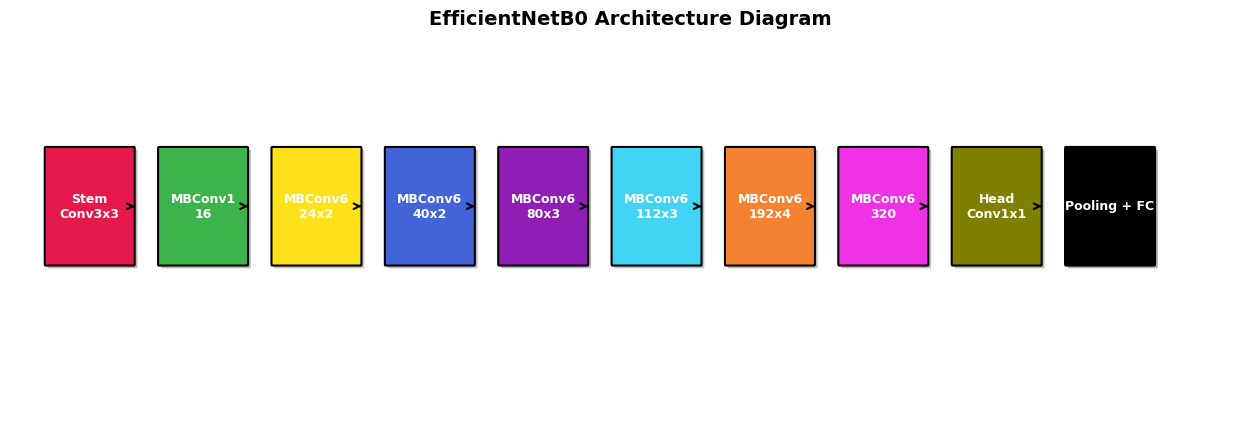

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects

def add_block(ax, x, y, width, height, label, color):
    rect = patches.FancyBboxPatch(
        (x, y), width, height,
        boxstyle="round,pad=0.02",
        linewidth=1.5, edgecolor='black', facecolor=color,
        path_effects=[path_effects.withSimplePatchShadow()]
    )
    ax.add_patch(rect)
    ax.text(
        x + width / 2, y + height / 2, label,
        ha='center', va='center', fontsize=9, color='white', weight='bold'
    )

def draw_efficientnet_b0():
    fig, ax = plt.subplots(figsize=(16, 5))
    ax.set_xlim(0, 35)
    ax.set_ylim(0, 5)
    ax.axis('off')

    x = 1  # starting x position
    y = 2  # fixed y position for all blocks

    block_width = 2.5
    block_height = 1.5

    # Define blocks as per EfficientNetB0 structure
    blocks = [
        ("Stem\nConv3x3", "#e6194B"),
        ("MBConv1\n16", "#3cb44b"),
        ("MBConv6\n24x2", "#ffe119"),
        ("MBConv6\n40x2", "#4363d8"),
        ("MBConv6\n80x3", "#911eb4"),
        ("MBConv6\n112x3", "#42d4f4"),
        ("MBConv6\n192x4", "#f58231"),
        ("MBConv6\n320", "#f032e6"),
        ("Head\nConv1x1", "#808000"),
        ("Pooling + FC", "#000000")
    ]

    # Draw blocks and arrows
    for idx, (label, color) in enumerate(blocks):
        add_block(ax, x, y, block_width, block_height, label, color)

        # Draw arrow except after last block
        if idx < len(blocks) - 1:
            ax.annotate(
                '',
                xy=(x + block_width + 0.1, y + block_height/2),
                xytext=(x + block_width - 0.1, y + block_height/2),
                arrowprops=dict(arrowstyle="->", color='black', lw=1.5),
            )
        x += block_width + 0.7  # move x for next block

    plt.title('EfficientNetB0 Architecture Diagram', fontsize=14, weight='bold')
    plt.show()

draw_efficientnet_b0()


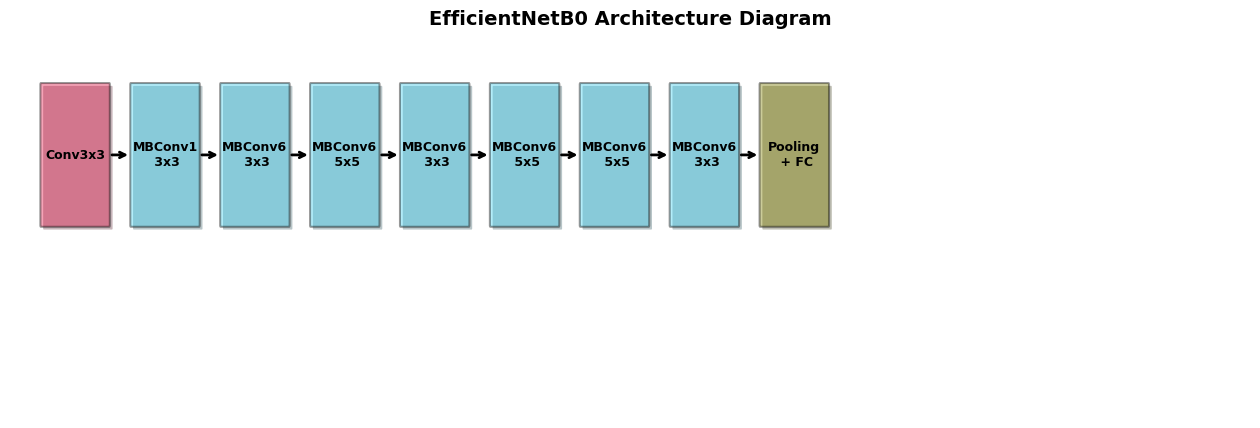

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects

def add_block(ax, x, y, width, height, label, color):
    rect = patches.FancyBboxPatch(
        (x, y), width, height,
        boxstyle="round,pad=0.02",
        linewidth=1.5, edgecolor='black', facecolor=color,alpha=0.4,
        path_effects=[path_effects.withSimplePatchShadow()]
    )
    ax.add_patch(rect)
    ax.text(
        x + width / 2, y + height / 2, label,
        ha='center', va='center', fontsize=9, color='black', weight='bold'
    )

def draw_efficientnet_b0():
    fig, ax = plt.subplots(figsize=(16, 5))
    ax.set_xlim(0, 40)
    ax.set_ylim(0, 6)
    ax.axis('off')

    x = 1  # starting x position
    y = 3  # fixed y position for all blocks

    block_width = 2.2  # decreased width
    block_height = 2.2  # increased height

    # Define blocks as per EfficientNetB0 structure
    blocks = [
        ("Conv3x3", "#e6194B"),
        ("MBConv1\n 3x3", "#42d4f4"),
        ("MBConv6\n 3x3", "#42d4f4"),
        ("MBConv6\n 5x5", "#42d4f4"),
        ("MBConv6\n 3x3", "#42d4f4"),
        ("MBConv6\n 5x5", "#42d4f4"),
        ("MBConv6\n 5x5", "#42d4f4"),
        ("MBConv6\n 3x3", "#42d4f4"),
        ("Pooling\n + FC", "#808000")
    ]

    for idx, (label, color) in enumerate(blocks):
        add_block(ax, x, y, block_width, block_height, label, color)

        # Draw arrow except after last block
        if idx < len(blocks) - 1:
            arrow_x_start = x + block_width
            arrow_x_end = x + block_width + 0.7
            ax.annotate(
                '',
                xy=(arrow_x_end, y + block_height / 2),
                xytext=(arrow_x_start, y + block_height / 2),
                arrowprops=dict(arrowstyle="->", color='black', lw=2),
            )
        x += block_width + 0.7  # move x for next block

    plt.title('EfficientNetB0 Architecture Diagram', fontsize=14, weight='bold')
    plt.show()

draw_efficientnet_b0()


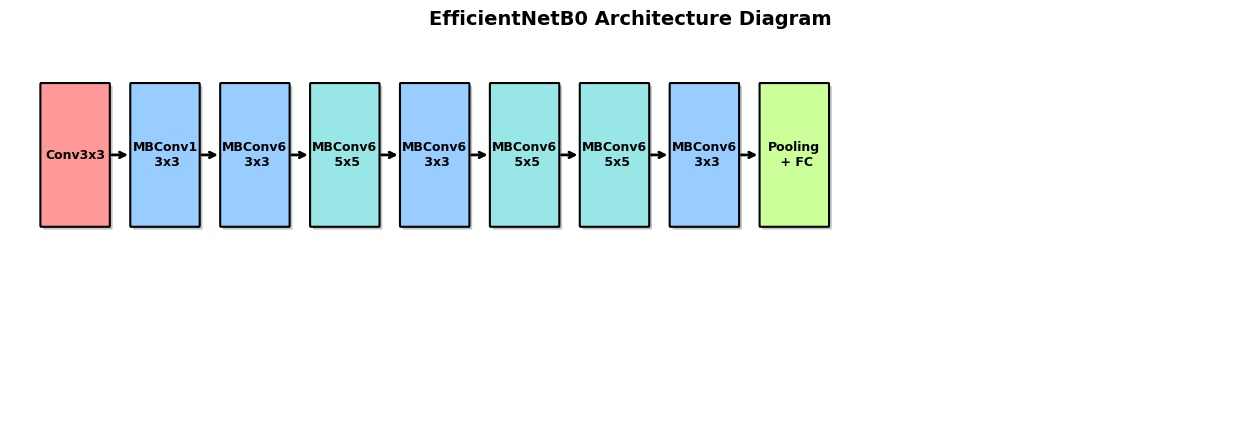

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects

def add_block(ax, x, y, width, height, label, color):
    rect = patches.FancyBboxPatch(
        (x, y), width, height,
        boxstyle="round,pad=0.02",
        linewidth=1.5, edgecolor='black', facecolor=color,
        path_effects=[path_effects.withSimplePatchShadow()]
    )
    ax.add_patch(rect)
    ax.text(
        x + width / 2, y + height / 2, label,
        ha='center', va='center', fontsize=9, color='black', weight='bold'
    )

def draw_efficientnet_b0():
    fig, ax = plt.subplots(figsize=(16, 5))
    ax.set_xlim(0, 40)
    ax.set_ylim(0, 6)
    ax.axis('off')

    x = 1  # starting x position
    y = 3  # fixed y position for all blocks

    block_width = 2.2  # decreased width
    block_height = 2.2  # increased height

    # Define blocks as per EfficientNetB0 structure with lighter colors
    blocks = [
        ("Conv3x3", "#ff9999"),      # light red
        ("MBConv1\n 3x3", "#99ccff"),  # light blue
        ("MBConv6\n 3x3", "#99ccff"),
        ("MBConv6\n 5x5", "#99e6e6"),  # light cyan
        ("MBConv6\n 3x3", "#99ccff"),
        ("MBConv6\n 5x5", "#99e6e6"),
        ("MBConv6\n 5x5", "#99e6e6"),
        ("MBConv6\n 3x3", "#99ccff"),
        ("Pooling\n + FC", "#ccff99")  # light green
    ]

    for idx, (label, color) in enumerate(blocks):
        add_block(ax, x, y, block_width, block_height, label, color)

        # Draw arrow except after last block
        if idx < len(blocks) - 1:
            arrow_x_start = x + block_width
            arrow_x_end = x + block_width + 0.7
            ax.annotate(
                '',
                xy=(arrow_x_end, y + block_height / 2),
                xytext=(arrow_x_start, y + block_height / 2),
                arrowprops=dict(arrowstyle="->", color='black', lw=2),
            )
        x += block_width + 0.7  # move x for next block

    plt.title('EfficientNetB0 Architecture Diagram', fontsize=14, weight='bold')
    plt.show()

draw_efficientnet_b0()


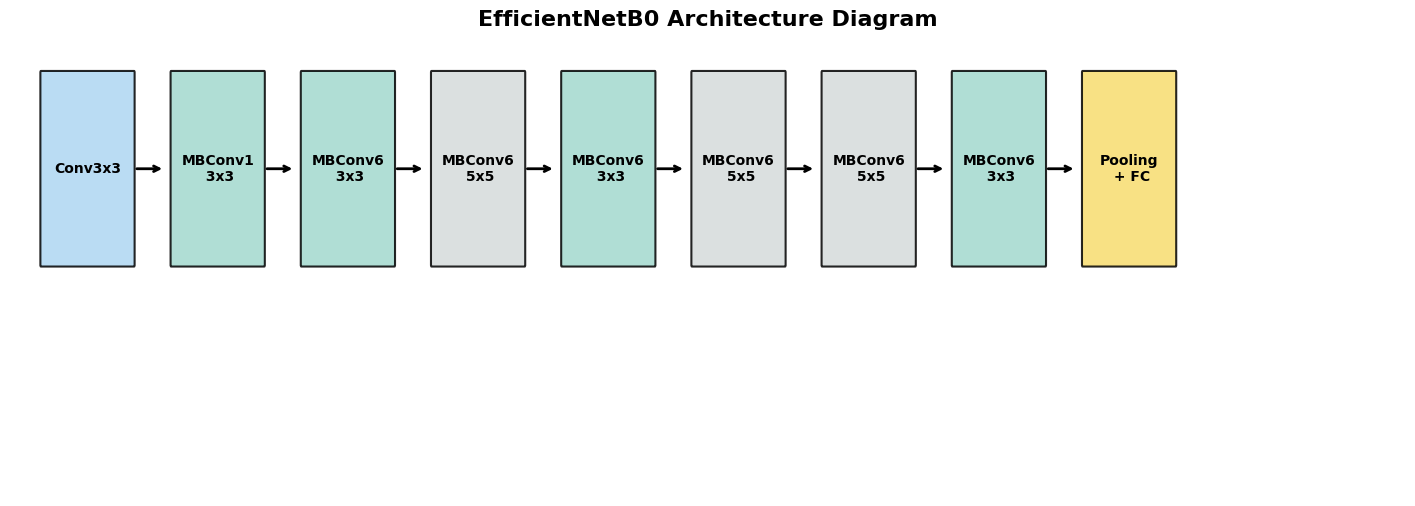

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def add_block(ax, x, y, width, height, label, color):
    rect = patches.FancyBboxPatch(
        (x, y), width, height,
        boxstyle="round,pad=0.02",
        linewidth=1.5, edgecolor='black', facecolor=color, alpha=0.85  # Adjusted alpha for clarity
    )
    ax.add_patch(rect)
    ax.text(
        x + width / 2, y + height / 2, label,
        ha='center', va='center', fontsize=10, color='black', weight='bold'
    )

def draw_efficientnet_b0():
    fig, ax = plt.subplots(figsize=(18, 6))  # Increased canvas size for clarity
    ax.set_xlim(0, 45)
    ax.set_ylim(0, 6)
    ax.axis('off')

    x = 1  # starting x position
    y = 3  # fixed y position for all blocks

    block_width = 3.0  # Adjusted width for balance
    block_height = 2.5  # Adjusted height for balance

    # Define blocks as per EfficientNetB0 structure with a more professional color scheme
    blocks = [
        ("Conv3x3", "#AED6F1"),      # Light blue
        ("MBConv1\n 3x3", "#A2D9CE"),  # Mint green
        ("MBConv6\n 3x3", "#A2D9CE"),
        ("MBConv6\n 5x5", "#D5DBDB"),  # Light grey
        ("MBConv6\n 3x3", "#A2D9CE"),
        ("MBConv6\n 5x5", "#D5DBDB"),
        ("MBConv6\n 5x5", "#D5DBDB"),
        ("MBConv6\n 3x3", "#A2D9CE"),
        ("Pooling\n + FC", "#F7DC6F")  # Light yellow
    ]

    for idx, (label, color) in enumerate(blocks):
        add_block(ax, x, y, block_width, block_height, label, color)

        # Draw arrow except after last block
        if idx < len(blocks) - 1:
            arrow_x_start = x + block_width
            arrow_x_end = x + block_width + 1.0  # Slightly increased arrow space for better separation
            ax.annotate(
                '',
                xy=(arrow_x_end, y + block_height / 2),
                xytext=(arrow_x_start, y + block_height / 2),
                arrowprops=dict(arrowstyle="->", color='black', lw=2),
            )
        x += block_width + 1.2  # Move x for next block

    plt.title('EfficientNetB0 Architecture Diagram', fontsize=16, weight='bold')
    plt.show()

draw_efficientnet_b0()


**Main Code**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import math

# Load the dataset
data = {
    "spindle_speed": [1000, 1000, 1100, 12000, 1100, 12000, 1100, 12000, 1000, 14000, 1000, 12000, 1100, 14000],
    "feed_rate": [0.3, 0.1, 0.1, 0.4, 0.3, 0.3, 0.4, 0.2, 0.4, 0.1, 0.2, 0.1, 0.2, 0.2],
    "filename": [f"{i}.jpg" for i in [0, 2, 5, 6, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19]],
    "depth": [0.12, 0.04, 0.05, 0.28, 0.18, 0.2, 0.22, 0.14, 0.16, 0.06, 0.08, 0.05, 0.1, 0.11],
    "length": [1.6, 0.9, 1.0, 3.2, 2.4, 2.6, 2.8, 1.9, 2.2, 1.1, 1.4, 1.0, 1.5, 1.8],
    "area": [0.192, 0.036, 0.05, 0.896, 0.432, 0.52, 0.616, 0.266, 0.352, 0.066, 0.112, 0.05, 0.15, 0.198]
}

df = pd.DataFrame(data)

# Preprocess numerical data
scaler = StandardScaler()
numerical_data = scaler.fit_transform(df[["spindle_speed", "feed_rate"]])
targets = np.column_stack([df["depth"], df["length"], df["area"]])

# Apply log transformation to depth
depth_transformed = np.log1p(df["depth"])

# Load and preprocess images
original_images = np.array([
    preprocess_input(image.img_to_array(image.load_img(f"/content/drive/MyDrive/Images/{fname}", target_size=(224, 224))))
    for fname in df["filename"]
])

# Data augmentation
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

augmented_images, augmented_numerical, augmented_targets = [], [], []
for img, num, tgt in zip(original_images, numerical_data, targets):
    img = np.expand_dims(img, 0)
    gen = datagen.flow(img, batch_size=1, shuffle=False)
    for _ in range(3):
        aug_img = gen.__next__()[0]
        augmented_images.append(aug_img)
        augmented_numerical.append(num)
        augmented_targets.append(tgt)

all_images = np.concatenate([original_images, np.array(augmented_images)])
all_numerical = np.concatenate([numerical_data, np.array(augmented_numerical)])
all_targets = np.concatenate([targets, np.array(augmented_targets)])

# Train-test split
X_img_train, X_img_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    all_images, all_numerical, all_targets, test_size=0.2, random_state=42
)

# Cosine Annealing LR
def cosine_annealing(epoch, lr):
    max_lr = 1e-2  # Increased max_lr for faster convergence
    min_lr = 1e-5
    return min_lr + (max_lr - min_lr) * (1 + math.cos(math.pi * epoch / 100)) / 2

cosine_callback = LearningRateScheduler(cosine_annealing)

# Image model
img_input = Input(shape=(224, 224, 3))
base_model = EfficientNetB0(include_top=False, input_tensor=img_input, pooling='avg')

# Fine-tune last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

img_features = base_model.output

# Numerical model
num_input = Input(shape=(2,))
x = layers.Dense(64, activation='relu')(num_input)
x = layers.RepeatVector(1)(x)
x = layers.Bidirectional(layers.GRU(32, return_sequences=True))(x)
attn_output = layers.MultiHeadAttention(num_heads=2, key_dim=16)(x, x)
attn_output = layers.GlobalAveragePooling1D()(attn_output)

# Added Dense layer for more complexity
x = layers.Dense(128, activation='relu')(attn_output)

# Fuse features
combined = layers.Concatenate()([img_features, x])
x = layers.Dense(128, activation='relu')(combined)
x = layers.Dropout(0.3)(x)

# Output heads
depth_output = layers.Dense(1, name='depth')(x)
length_output = layers.Dense(1, name='length')(x)
area_output = layers.Dense(1, name='area')(x)

model = Model(inputs=[img_input, num_input], outputs=[depth_output, length_output, area_output])
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=['mse', 'mse', 'mse'],
    loss_weights=[2.0, 1.0, 1.2],  # Boost Depth weight further
    metrics=['mae', 'mae', 'mae']
)

# Train
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    [X_img_train, X_num_train], [np.log1p(y_train[:, 0]), y_train[:, 1], y_train[:, 2]],  # Apply log to depth during training
    validation_split=0.2,
    epochs=100,
    batch_size=8,
    callbacks=[early_stop, cosine_callback],
    verbose=2
)

# Evaluate
loss, depth_loss, length_loss, area_loss, depth_mae, length_mae, area_mae = model.evaluate(
    [X_img_test, X_num_test], [np.log1p(y_test[:, 0]), y_test[:, 1], y_test[:, 2]]  # Apply log to depth during testing
)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test MAE (Depth): {depth_mae:.4f}")
print(f"Test MAE (Length): {length_mae:.4f}")
print(f"Test MAE (Area): {area_mae:.4f}")

# Predict once to avoid retracing warning
y_pred = model.predict([X_img_test, X_num_test], verbose=0)

# Inverse transform depth predictions
y_pred[0] = np.expm1(y_pred[0])  # Inverse log transformation for depth

depth_r2 = r2_score(np.expm1(y_test[:, 0]), y_pred[0])  # Inverse log transformation for ground truth depth
length_r2 = r2_score(y_test[:, 1], y_pred[1])
area_r2 = r2_score(y_test[:, 2], y_pred[2])

print(f"\nR² Score (Depth):  {depth_r2:.4f}")
print(f"R² Score (Length): {length_r2:.4f}")
print(f"R² Score (Area):   {area_r2:.4f}")


Epoch 1/100
5/5 - 22s - 4s/step - area_loss: 0.5107 - area_mae: 0.5206 - depth_loss: 1.7084 - depth_mae: 1.0044 - length_loss: 5.0771 - length_mae: 1.9384 - loss: 9.0938 - val_area_loss: 5.2012 - val_area_mae: 2.4310 - val_depth_loss: 208.8849 - val_depth_mae: 15.6260 - val_length_loss: 19.0749 - val_length_mae: 4.3054 - val_loss: 547.7795 - learning_rate: 0.0100
Epoch 2/100
5/5 - 0s - 82ms/step - area_loss: 0.8901 - area_mae: 0.7076 - depth_loss: 0.7910 - depth_mae: 0.7222 - length_loss: 2.3050 - length_mae: 1.2197 - loss: 5.1783 - val_area_loss: 4.7838 - val_area_mae: 2.1358 - val_depth_loss: 356.4970 - val_depth_mae: 21.0766 - val_length_loss: 1497.1324 - val_length_mae: 39.8739 - val_loss: 2555.4944 - learning_rate: 0.0100
Epoch 3/100
5/5 - 0s - 78ms/step - area_loss: 0.3888 - area_mae: 0.5231 - depth_loss: 0.3225 - depth_mae: 0.4651 - length_loss: 0.6560 - length_mae: 0.6555 - loss: 1.8074 - val_area_loss: 86.3146 - val_area_mae: 5.3614 - val_depth_loss: 13.4596 - val_depth_mae: 3

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model

def custom_predict(img_path, spindle_speed, feed_rate, exp_depth, exp_length, exp_area, save_csv=False, csv_path="results.csv"):
    # 1. Preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dim

    # 2. Preprocess numerical input (fixes the scaler warning)
    num_input = np.array([[spindle_speed, feed_rate]])
    num_input_scaled = scaler.transform(pd.DataFrame(num_input, columns=scaler.feature_names_in_))

    # 3. Auto-detect intermediate layers

    # Find last EfficientNet block layer for image features
    efficient_layer_name = None
    for layer in reversed(model.layers):
        if "block" in layer.name and "project_bn" in layer.name:
            efficient_layer_name = layer.name
            break

    # Find BiGRU or Attention layer for numerical features
    bigru_layer_name = None
    for layer in model.layers:
        if "global_average_pooling1d" in layer.name or "gru" in layer.name:
            bigru_layer_name = layer.name
            break

    # Sanity check
    if efficient_layer_name is None or bigru_layer_name is None:
        raise ValueError("Could not auto-detect intermediate layers.")

    # 4. Extract intermediate outputs
    # EfficientToolNet output (Image features)
    efficient_model = Model(inputs=model.input, outputs=model.get_layer(efficient_layer_name).output)
    efficient_output = efficient_model.predict([img_array, num_input_scaled], verbose=0).flatten()

    # BiGRU + Attention output (Numerical features)
    bigru_model = Model(inputs=model.input, outputs=model.get_layer(bigru_layer_name).output)
    bigru_output = bigru_model.predict([img_array, num_input_scaled], verbose=0).flatten()

    # 5. Get Final Prediction
    y_pred = model.predict([img_array, num_input_scaled], verbose=0)
    y_pred_depth = np.expm1(y_pred[0][0][0])  # Inverse log for depth
    y_pred_length = y_pred[1][0][0]
    y_pred_area = y_pred[2][0][0]

    # 6. Print Outputs
    print(f"\n=== EfficientToolNet Features (Flattened, {len(efficient_output)} dims) ===")
    print(efficient_output)

    print(f"\n=== BiGRU + Attention Features (Flattened, {len(bigru_output)} dims) ===")
    print(bigru_output)

    print("\n=== Table-Ready Row ===")
    row = {
        "Spindle Speed": spindle_speed,
        "Feed Rate": feed_rate,
        "Pred Depth": round(y_pred_depth, 4),
        "Pred Length": round(y_pred_length, 4),
        "Pred Area": round(y_pred_area, 4),
        "Exp Depth": exp_depth,
        "Exp Length": exp_length,
        "Exp Area": exp_area,
    }
    row_df = pd.DataFrame([row])
    print(row_df.to_string(index=False))

    # 7. Optionally Save to CSV
    if save_csv:
        # Efficient & BiGRU features added as flattened list
        for i, val in enumerate(efficient_output):
            row[f"EffFeat_{i+1}"] = val
        for i, val in enumerate(bigru_output):
            row[f"BiGRUFeat_{i+1}"] = val

        # Append to CSV
        try:
            df_existing = pd.read_csv(csv_path)
            df_new = pd.concat([df_existing, pd.DataFrame([row])], ignore_index=True)
        except FileNotFoundError:
            df_new = pd.DataFrame([row])

        df_new.to_csv(csv_path, index=False)
        print(f"\n✅ Saved to CSV: {csv_path}")

# Example Usage
custom_predict(
    img_path="/content/drive/MyDrive/Images/16.jpg",
    spindle_speed=12000,
    feed_rate=0.2,
    exp_depth=0.11,
    exp_length=1.8,
    exp_area=0.198,
    save_csv=False  # ✅ Enable CSV saving
)



=== EfficientToolNet Features (Flattened, 15680 dims) ===
[ 3.6957078  2.2197897 -5.607527  ...  1.8892729 -0.9281915  1.9102962]

=== BiGRU + Attention Features (Flattened, 64 dims) ===
[-0.02784194  0.06772926 -0.03866781 -0.01810243 -0.02558254  0.00993453
 -0.01732331  0.15181735 -0.10126082 -0.01723838  0.05757393  0.09581956
  0.05148514  0.02660275 -0.02724245 -0.08040121 -0.10689282 -0.02276244
  0.05303768 -0.01536828  0.01935858 -0.03560718 -0.02145413  0.16936068
 -0.0714974   0.00689203  0.04080047  0.09597549 -0.01799091  0.04561508
 -0.07141399 -0.01794027  0.01046203  0.10968114 -0.01343244 -0.12432038
 -0.05713205 -0.12243573 -0.02896389 -0.02249107  0.06878313  0.02879667
 -0.03723997  0.04305273 -0.05454745 -0.01584979 -0.09899372  0.00561391
 -0.00396914  0.01141107 -0.01515409 -0.02948322  0.01228026  0.07641108
  0.06602836  0.15207943 -0.07553875 -0.02178258 -0.03581473  0.00675375
 -0.02818231  0.05676831 -0.07688528  0.06162637]

=== Table-Ready Row ===
 Spindl

<ipython-input-6-f349125cd3c3>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(r2_scores.keys()), y=list(r2_scores.values()), palette="viridis")


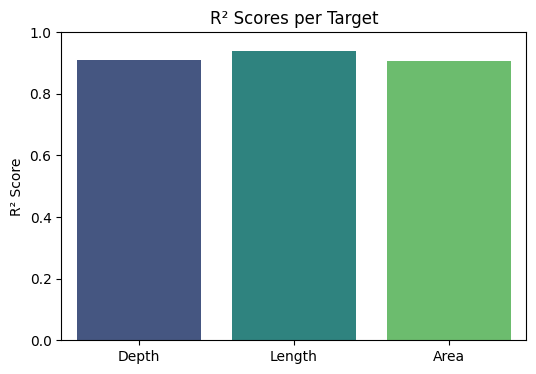

<ipython-input-6-f349125cd3c3>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(mae_scores.keys()), y=list(mae_scores.values()), palette="magma")


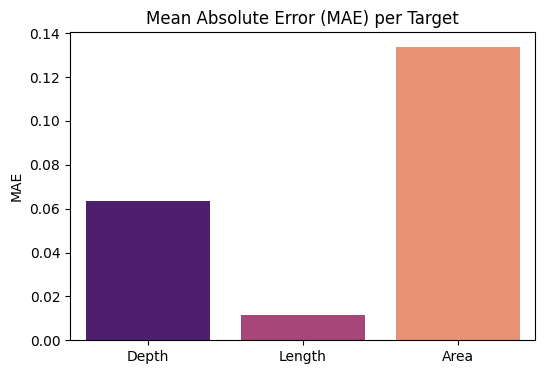

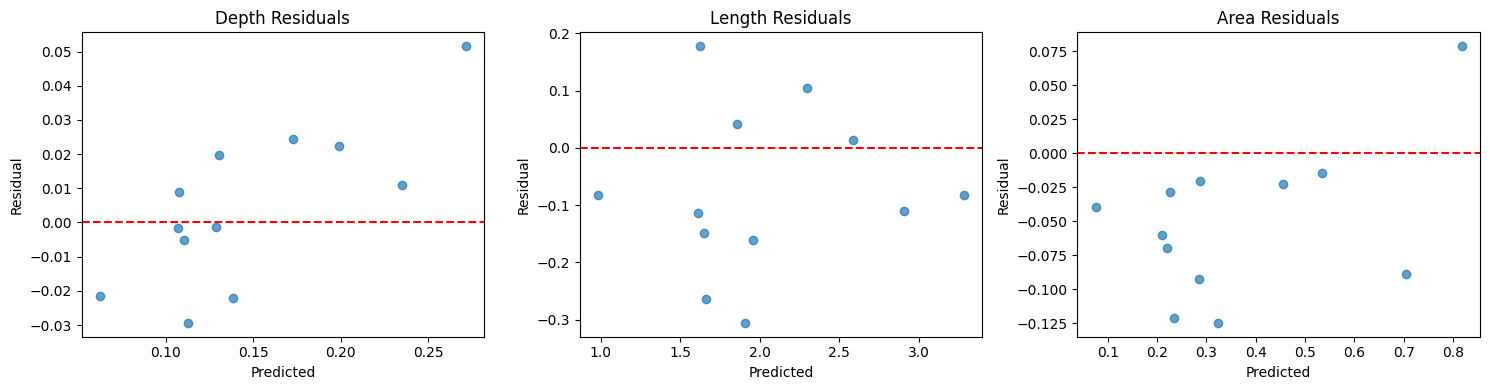

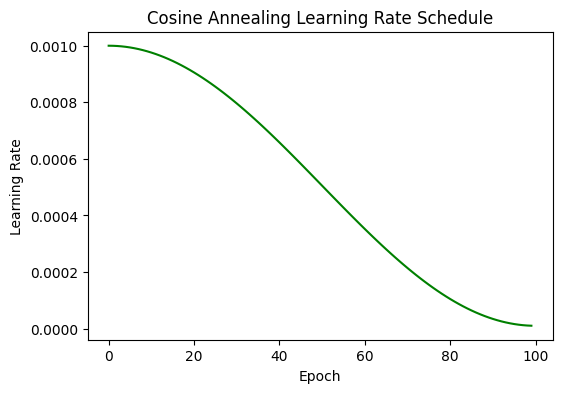

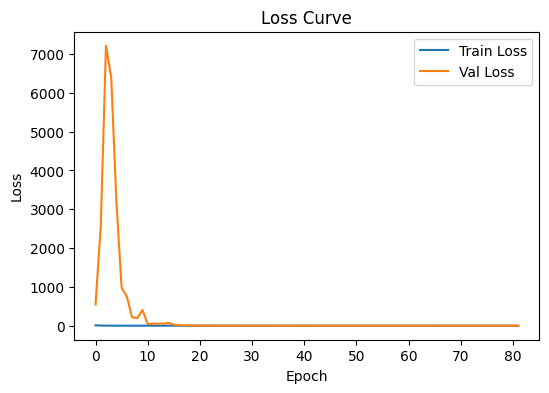

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ === R² Score Bar Chart ===
r2_scores = {
    'Depth': depth_r2,
    'Length': length_r2,
    'Area': area_r2
}

plt.figure(figsize=(6, 4))
sns.barplot(x=list(r2_scores.keys()), y=list(r2_scores.values()), palette="viridis")
plt.ylim(0, 1)
plt.title('R² Scores per Target')
plt.ylabel('R² Score')
plt.show()

# ✅ === MAE Bar Chart ===
mae_scores = {
    'Depth': depth_mae,
    'Length': length_mae,
    'Area': area_mae
}

plt.figure(figsize=(6, 4))
sns.barplot(x=list(mae_scores.keys()), y=list(mae_scores.values()), palette="magma")
plt.title('Mean Absolute Error (MAE) per Target')
plt.ylabel('MAE')
plt.show()

# ✅ === Residual Plots (True - Predicted) ===
depth_true = np.expm1(y_test[:, 0])   # Inverse log1p
depth_pred = y_pred[0].flatten()
length_true = y_test[:, 1]
length_pred = y_pred[1].flatten()
area_true = y_test[:, 2]
area_pred = y_pred[2].flatten()

targets = {
    'Depth': (depth_true, depth_pred),
    'Length': (length_true, length_pred),
    'Area': (area_true, area_pred)
}

plt.figure(figsize=(15, 4))
for i, (name, (true_vals, pred_vals)) in enumerate(targets.items()):
    plt.subplot(1, 3, i+1)
    residuals = true_vals - pred_vals
    plt.scatter(pred_vals, residuals, alpha=0.7)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'{name} Residuals')
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
plt.tight_layout()
plt.show()

# ✅ === Learning Rate Schedule Plot ===
def cosine_annealing(epoch, lr, total_epochs=100, initial_lr=1e-3, min_lr=1e-5):
    return min_lr + 0.5 * (initial_lr - min_lr) * (1 + np.cos(np.pi * epoch / total_epochs))

epochs = list(range(100))
lrs = [cosine_annealing(e, 0) for e in epochs]

plt.figure(figsize=(6, 4))
plt.plot(epochs, lrs, color='green')
plt.title('Cosine Annealing Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

# ✅ === Loss Curve (Train vs Val Loss) ===
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


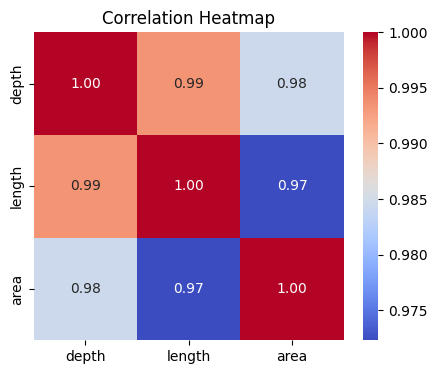

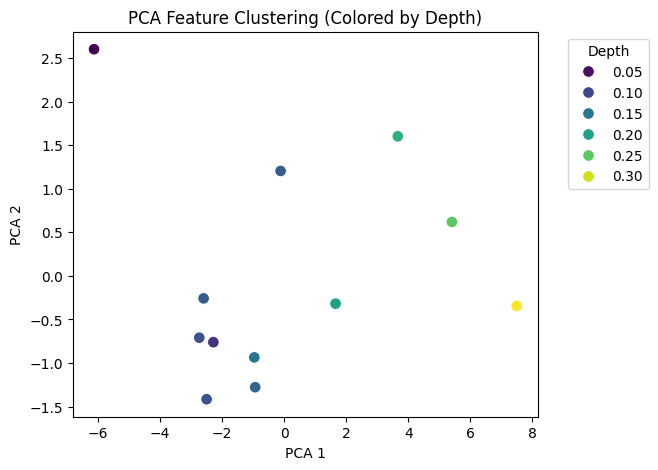

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


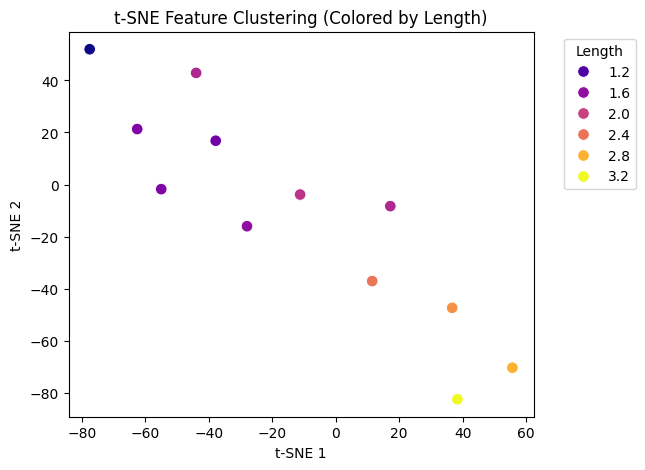

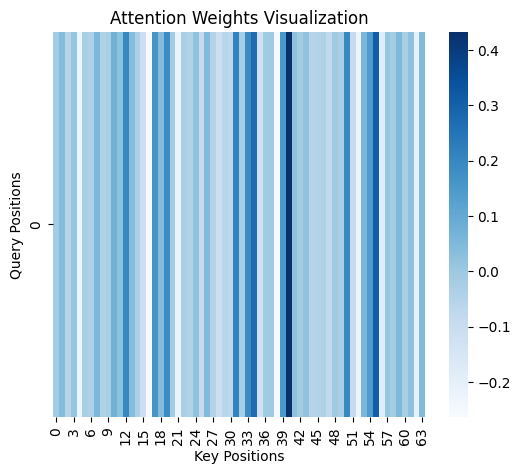

TypeError: list indices must be integers or slices, not tuple

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.models import Model

# ✅ --- Correlation Heatmap (Depth vs Length vs Area) ---
plt.figure(figsize=(5, 4))
corr = df[['depth', 'length', 'area']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# ✅ --- Feature Extraction (before output layer) ---
# Get features from model's penultimate Dense layer
feature_extractor = Model(inputs=model.inputs, outputs=model.layers[-4].output)
features = feature_extractor.predict([X_img_test, X_num_test], verbose=0)

# Get true values for coloring
depth_true = np.expm1(y_test[:, 0])  # inverse log
length_true = y_test[:, 1]
area_true = y_test[:, 2]

# ✅ --- PCA Feature Clustering ---
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=np.round(depth_true, 2), palette='viridis', s=70)
plt.title('PCA Feature Clustering (Colored by Depth)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Depth')
plt.show()

# ✅ --- t-SNE Feature Clustering ---
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=1000)
tsne_features = tsne.fit_transform(features)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=np.round(length_true, 2), palette='plasma', s=70)
plt.title('t-SNE Feature Clustering (Colored by Length)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Length')
plt.show()

# ✅ --- Attention Weights Visualization (fixed version) ---
# Find the attention layer
attn_layer = None
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.MultiHeadAttention):
        attn_layer = layer
        break

if attn_layer is not None:
    # Build intermediate model to output attention scores
    attn_model = Model(inputs=model.inputs, outputs=attn_layer.output)

    # Get sample input
    sample_num = X_num_test[:1]
    sample_img = X_img_test[:1]

    # Get attention output
    attn_output = attn_model.predict([sample_img, sample_num], verbose=0)

    # ✅ If output is (batch_size, query_len, key_len), average over batch
    if attn_output.ndim == 3:
        attn_weights = attn_output[0]  # shape: (query_len, key_len)
    elif attn_output.ndim == 4:
        attn_weights = np.mean(attn_output[0], axis=0)  # average over heads
    else:
        raise ValueError(f"Unexpected attention output shape: {attn_output.shape}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(attn_weights, cmap='Blues', cbar=True)
    plt.title('Attention Weights Visualization')
    plt.xlabel('Key Positions')
    plt.ylabel('Query Positions')
    plt.show()
else:
    print("❌ No MultiHeadAttention layer found in the model!")

# ✅ BONUS 1 --- Actual vs Predicted Scatter Plots ---
y_pred = model.predict([X_img_test, X_num_test], verbose=0)
depth_pred = np.expm1(y_pred[:, 0])
length_pred = y_pred[:, 1]
area_pred = y_pred[:, 2]

plt.figure(figsize=(15, 4))
for i, (true, pred, name) in enumerate(zip([depth_true, length_true, area_true],
                                           [depth_pred, length_pred, area_pred],
                                           ['Depth', 'Length', 'Area'])):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=true, y=pred, alpha=0.7)
    plt.plot([min(true), max(true)], [min(true), max(true)], 'r--')  # perfect line
    plt.xlabel(f'True {name}')
    plt.ylabel(f'Predicted {name}')
    plt.title(f'{name}: Actual vs Predicted')
plt.tight_layout()
plt.show()

# ✅ BONUS 2 --- Residual Error Distribution ---
plt.figure(figsize=(15, 4))
for i, (true, pred, name) in enumerate(zip([depth_true, length_true, area_true],
                                           [depth_pred, length_pred, area_pred],
                                           ['Depth', 'Length', 'Area'])):
    residuals = true - pred
    plt.subplot(1, 3, i+1)
    sns.histplot(residuals, kde=True, bins=30, color='purple')
    plt.xlabel(f'Residuals ({name})')
    plt.title(f'{name} Residual Distribution')
plt.tight_layout()
plt.show()


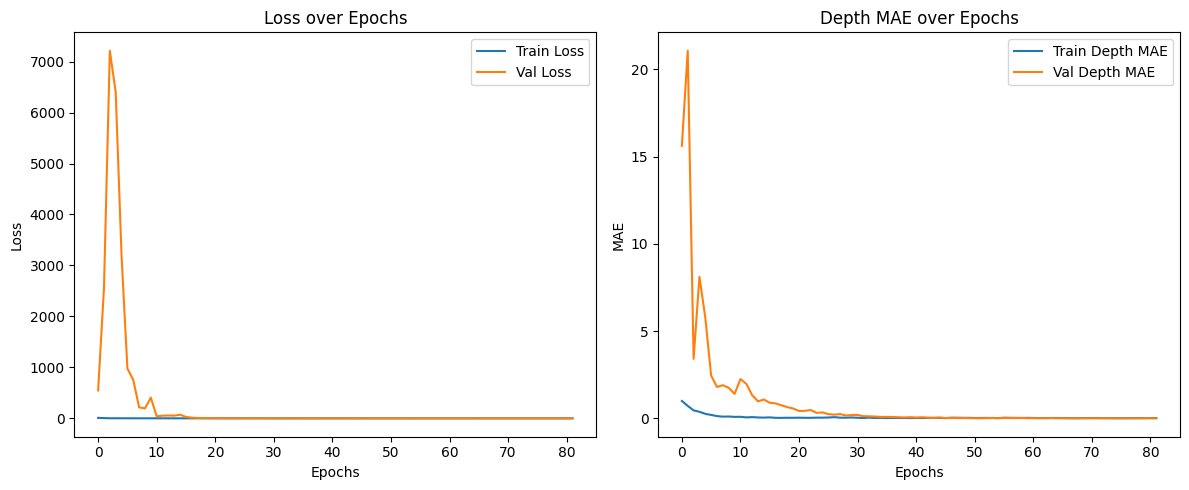

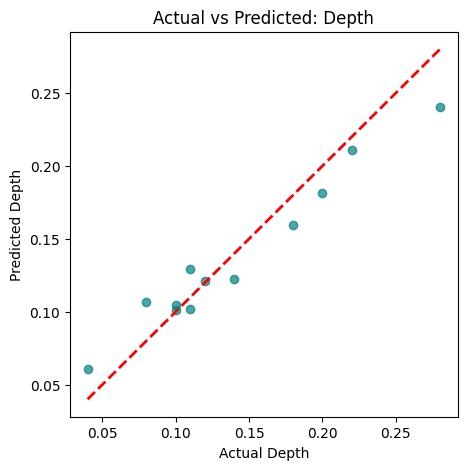

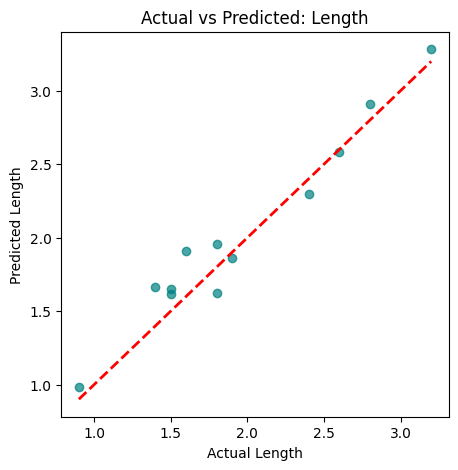

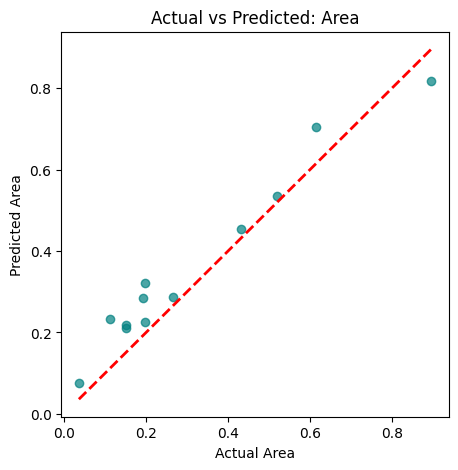

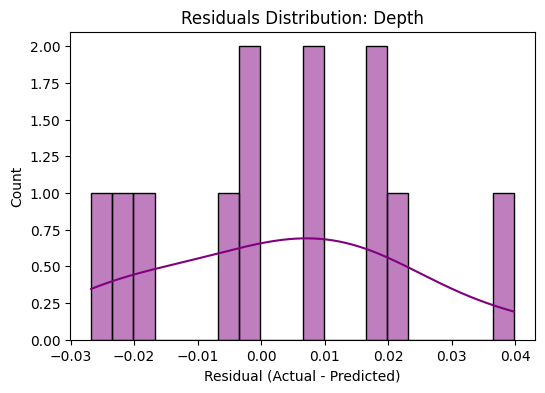

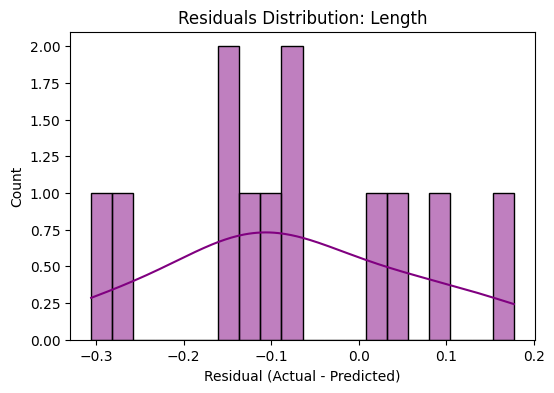

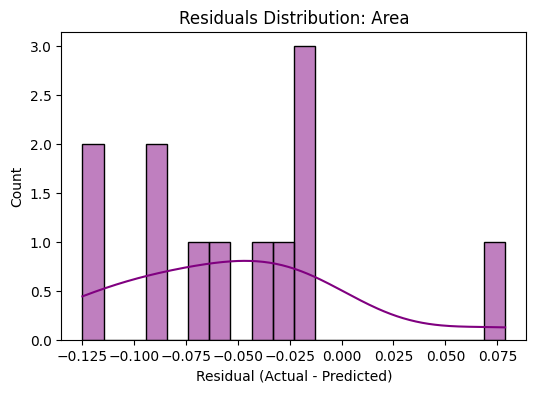

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ 1) Loss & MAE Curve
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# MAE Curve (using Depth MAE as example)
plt.subplot(1, 2, 2)
plt.plot(history.history['depth_mae'], label='Train Depth MAE')
plt.plot(history.history['val_depth_mae'], label='Val Depth MAE')
plt.title('Depth MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


# ✅ 2) Predicted vs Actual Scatter Plot
target_names = ['Depth', 'Length', 'Area']

for i in range(3):
    plt.figure(figsize=(5, 5))
    plt.scatter(y_test[:, i], y_pred[i].flatten(), alpha=0.7, color='teal')
    plt.plot([y_test[:, i].min(), y_test[:, i].max()],
             [y_test[:, i].min(), y_test[:, i].max()],
             'r--', lw=2)
    plt.xlabel('Actual ' + target_names[i])
    plt.ylabel('Predicted ' + target_names[i])
    plt.title(f'Actual vs Predicted: {target_names[i]}')
    plt.show()


# ✅ 3) Residuals Plot
for i in range(3):
    residuals = y_test[:, i] - y_pred[i].flatten()
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, color='purple', bins=20)
    plt.title(f'Residuals Distribution: {target_names[i]}')
    plt.xlabel('Residual (Actual - Predicted)')
    plt.show()
